# Ressources

In [58]:
import pandas as pd 
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
import sklearn.metrics
from xgboost import XGBRegressor
from sklearn import svm
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# supprime les FutureWarnings dû à l'utilisation de pandas (.append/.drop)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')


# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"


# Import data

In [59]:
df = pd.read_csv('data_final.csv')
df_energystar = pd.read_csv('data_energystar.csv')
df

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,LargestPropertyUseTypeGFA_avg,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg,PropertyGFABuilding(s)_%,PropertyGFAParking_%,Dureedevie
0,1,NonResidential,1.0,12.0,47.61220,-122.33799,Hotel/Senior Care/Housing,88434.0,0.0,88434.0,88434.0,7.103895e+06,249.705,1.00,0.00,89
1,2,NonResidential,1.0,11.0,47.61317,-122.33393,Hotel/Senior Care/Housing,103566.0,15064.0,88502.0,83880.0,8.371084e+06,279.685,0.85,0.15,20
2,3,NonResidential,1.0,41.0,47.61393,-122.33810,Hotel/Senior Care/Housing,959050.0,98359.0,860691.0,756868.0,7.285884e+07,2075.380,0.90,0.10,47
3,5,NonResidential,1.0,10.0,47.61412,-122.33664,Hotel/Senior Care/Housing,61320.0,0.0,61320.0,61320.0,1.751195e+07,1111.385,1.00,0.00,90
4,8,NonResidential,1.0,18.0,47.61375,-122.34047,Hotel/Senior Care/Housing,147735.0,37230.0,110505.0,123445.0,1.450085e+07,506.355,0.75,0.25,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,50222,Nonresidential COS,1.0,1.0,47.56722,-122.31154,Office,12294.0,0.0,12294.0,12294.0,8.497457e+05,20.940,1.00,0.00,26
1680,50223,Nonresidential COS,1.0,1.0,47.59625,-122.32283,Loisirs,16000.0,0.0,16000.0,16000.0,9.502762e+05,32.170,1.00,0.00,12
1681,50224,Nonresidential COS,1.0,1.0,47.63644,-122.35784,Loisirs,13157.0,0.0,13157.0,7583.0,5.765898e+06,223.540,1.00,0.00,42
1682,50225,Nonresidential COS,1.0,1.0,47.52832,-122.32431,Loisirs,14101.0,0.0,14101.0,6601.0,7.194712e+05,22.110,1.00,0.00,27


# Fonctions


## Fonctions Filtrage

In [60]:
def df_filtre_categorical(df):
    categorical_columns = df.select_dtypes(['object']).columns
    categorical_columns
    # LargestPropertyUseType donne assez d'informations pour notre modèle.
    categorical_columns = categorical_columns.drop(['BuildingType'])
    return categorical_columns

def df_filtre_numerical(df):
    numerical_columns = df.select_dtypes(['int64', 'float64']).columns

    numerical_columns = numerical_columns.drop('OSEBuildingID')  # cette variable n'influence pas la consommation
    numerical_columns = numerical_columns.drop(['Longitude', 'Latitude'])  # tout se déroule à Seattle.. pas pertinent
    numerical_columns = numerical_columns.drop(['PropertyGFAParking_avg', 'PropertyGFABuilding(s)_avg']) # si on prend les colonnes %
    numerical_columns = numerical_columns.drop(['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg'])  # variables Y
    return numerical_columns

## Fonctions Encodage

In [61]:
# https://datagy.io/sklearn-one-hot-encode/

def df_encodage_categorie(df:pd.DataFrame, categorical_columns:list):

    ohe = OneHotEncoder(sparse=False)  # Will return sparse matrix if set True else will return an array.
    cat_enc = ohe.fit_transform(df[categorical_columns])

    df_ohe = pd.DataFrame(cat_enc)
    return ohe, df_ohe



## Fonctions Evaluation des modèles

In [62]:
def training_model(df_train, Y_target, test_size=0.33, random_state=42):
    
    # on peut essayer de trouver les paramètres optimaux avec GridSearchSV. Toutefois, étant donné que c'est la première fois, on va privilégier une validation_curve pour que je les trouve moi-même !
    
    # Src : https://www.youtube.com/watch?v=w_bLGK4Pteo (cross validation score / validation_curve)
    
    
    # listes qui vont servir à créer un dataframe
    score_training_liste = []
    cross_liste = []
    mae_liste = []
    mse_liste = []
    rmse_liste = []
      
    
    # la variable visée
    
    X_train, X_test, y_train, y_test = train_test_split(df_train,
                                                    Y_target,
                                                    test_size=test_size,
                                                    random_state=random_state)
    
    ss = StandardScaler()
    
    X_train = ss.fit_transform(X_train) 
    X_test = ss.transform(X_test)
    
    # les algos qu'on va tester
    algos = {
    'LinearRegression' : LinearRegression(),
    'Lasso' : Lasso(tol=0.5),
    'Ridge' : Ridge(),
    'ElasticNet' : ElasticNet(),
    'RandomForestRegressor' : RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1),
    'SVR' : svm.SVR(cache_size=7000, max_iter=1000)
}
    # les hyper paramètres qu'on va faire varier pour trouver le meilleur score
    hyperparametres = {
    'LinearRegression' : ['n_jobs', np.arange(1,50)],  # The number of jobs to use for the computation
    'Lasso' : ['alpha', np.arange(0.01,1, 0.05)],
    'Ridge' : ['alpha', np.arange(0.01,1, 0.05)],
    'ElasticNet' : ['alpha', np.arange(0.01, 1, 0.05)],
    'RandomForestRegressor' : ['n_estimators', [20,50,100,500,1000,2000]],  #nombre d'arbres dans la foret
    'XGBRegressor': ['n_estimators', [20,50,100,500,1000,2000]], # nombre d'arbres dans la foret
    'SVR' : ['gamma', [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]]
}
    # on teste
    for algo_name, algo in algos.items():
        model = algo.fit(X_train, y_train)
        score_entrainement = model.score(X_test, y_test)
        cross_validation = cross_val_score(algo, X_train, y_train, cv=5).mean() # permet de découper le trainset en 5 parties et de tester. On fait ensuite la moyenne des notes :)
        train_score, val_score = validation_curve(algo, X_train, y_train, param_name=hyperparametres[algo_name][0], param_range=hyperparametres[algo_name][1], cv=5)
        predict = model.predict(X_test)
        
        
    #Pour évaluer un modèle de régression, on peut calculer la distance entre valeurs prédites et vraies valeurs. Cela nous donne :
    #la somme des carrés des résidus (RSS) ;
    # la moyenne de cette somme (MSE) ;
    # la racine carrée de cette moyenne (RMSE).
        mae = sklearn.metrics.mean_absolute_error(y_test, predict) # Mean absolute error regression loss.
        mse = np.square(np.subtract(y_test,predict)).mean() 
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, predict)) # Mean squared error regression loss.

        # on ajoute les résultats dans les listes pour le dataframe
        score_training_liste.append(score_entrainement) # note : r2_score donne le mm resultat
        cross_liste.append(cross_validation)
        mae_liste.append(mae)
        mse_liste.append(mse)
        rmse_liste.append(rmse)
        
        # on affiche les résultats

        
        print(algo_name)
        print('Score entrainement: ' + str(score_entrainement))
        print('Cross: ' + str(cross_validation))

        '''
        The mean absolute error measures the average differences between predicted values and actual values
        Unlike the mean squared error (MSE), the MAE calculates the error on the same scale as the data. This means it’s easier to interpret.
        The MAE doesn’t square the differences and is less susceptible to outliers
        Both values are negatively-oriented. This means that, while both range from 0 to infinity, lower values are better.
        For example, in our earlier example of a MAE of 10, if the values ranged from 10,000 to 100,000 a MAE of 10 would be great. However, if the values ranged from 0 through 20, a MAE would be terrible.
        Src : https://datagy.io/mae-python/
        '''
        
        print('MAE : ' + str(mae))
        
        # So, MSE is a risk function that helps us determine the average squared difference between the predicted and the actual value of a feature or variable.
        
        print('MSE : ' + str(mse))
        
        '''
        RMSE is an acronym for Root Mean Square Error, which is the square root of value obtained from Mean Square Error function.

        Using RMSE, we can easily plot a difference between the estimated and actual values of a parameter of the model.

        By this, we can clearly judge the efficiency of the model.

        Usually, a RMSE score of less than 180 is considered a good score for a moderately or well working algorithm. 
        In case, the RMSE value exceeds 180, we need to perform feature selection and hyper parameter tuning on the parameters of the model.
        '''
        
        print('RMSE : ' + str(rmse))
        
        
        # Graphique des résultats
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        ax1.scatter(y_test, predict, c='coral')
        ax1.set_title(f'Prediction : {Y_target.name} avec {algo_name}')
        ax1.set_xlabel("Vraies valeurs", size = 12)
        ax1.set_ylabel("Valeurs prédictes", size = 12)
        
        ax2.plot(hyperparametres[algo_name][1], val_score.mean(axis=1), label="validation")
        ax2.plot(hyperparametres[algo_name][1], train_score.mean(axis=1), label="train")
        ax2.set_title(f'Validation curve ({algo_name})')
        ax2.set_xlabel(hyperparametres[algo_name][0], size = 12)
        ax2.set_ylabel("score", size = 12)
        ax2.legend()
        
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

        plt.show()
        
        print('--------')
        
    # le dataframe
        
    df_liste = pd.DataFrame([algos.keys(), score_training_liste, cross_liste, mae_liste, mse_liste, rmse_liste])
    df_liste = df_liste.transpose()
    df_liste = df_liste.rename(columns={0:'Model', 1:'Score training', 2: 'Cross Validation', 3: 'MAE', 4:'MSE', 5:'RMSE'})
        
    return df_liste



def predict_optuna(df, var_target, hyperparametres):
    
    
    X_train, X_test, y_train, y_test = train_test_split(df,
                                                        var_target,
                                                        test_size=0.33,
                                                        random_state=0)
    
    ss = StandardScaler()
    
    X_train = ss.fit_transform(X_train) 
    X_test = ss.transform(X_test)
    
    classifier = hyperparametres.params['classifier']
    del hyperparametres.params['classifier']
    
    if classifier == 'XGBRegressor':
        model = XGBRegressor(**hyperparametres.params)
    elif classifier == 'SVR':
        model = svm.SVR(**hyperparametres.params)
    elif classifier == 'RandomForest':
        model = RandomForestRegressor(**hyperparametres.params)
    model.fit(X_train, y_train)
    
    print(model.score(X_test, y_test))
    print(cross_val_score(model, X_train, y_train, cv=5).mean())
    
    return classifier, model

## Fonction Feature Importance

In [63]:
def feature_importance(model, classifier, index):
    df_features = pd.DataFrame(model.feature_importances_, index=index)
    fig = px.histogram(x=df_features[0], y=df_features.index, color=df_features.index, title="Features importance " + str(classifier), width=1600, height=1400).update_yaxes(categoryorder="total ascending")
    fig.update_layout(showlegend=False)
    return fig

# Prediction sans EnergyStarScore
<span style="color: #00B0F0">Variables à prédire : TotalGHGEmissions et SiteEnergyUse(kBtu)</span>

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1684 non-null   int64  
 1   BuildingType                   1684 non-null   object 
 2   NumberofBuildings              1684 non-null   float64
 3   NumberofFloors                 1684 non-null   float64
 4   Latitude                       1684 non-null   float64
 5   Longitude                      1684 non-null   float64
 6   LargestPropertyUseType         1684 non-null   object 
 7   PropertyGFATotal_avg           1684 non-null   float64
 8   PropertyGFAParking_avg         1684 non-null   float64
 9   PropertyGFABuilding(s)_avg     1684 non-null   float64
 10  LargestPropertyUseTypeGFA_avg  1684 non-null   float64
 11  SiteEnergyUse(kBtu)_avg        1684 non-null   float64
 12  TotalGHGEmissions_avg          1684 non-null   f

## Séparation des types de variables

Pour séparer les variables ... et comme c'est la première fois, je vais le faire à la main.
Néanmoins, pour les prochains, il peut être utile d'utiliser make_pipeline et make_column_transformer (Tuto here : https://www.youtube.com/watch?v=41mnga4ptso)

In [65]:
categorical_columns = df_filtre_categorical(df)

In [66]:
numerical_columns = df_filtre_numerical(df)
numerical_columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal_avg',
       'LargestPropertyUseTypeGFA_avg', 'PropertyGFABuilding(s)_%',
       'PropertyGFAParking_%', 'Dureedevie'],
      dtype='object')

## Variables object

In this tutorial, you’ll learn how to use the OneHotEncoder class in Scikit-Learn to one hot encode your categorical data in sklearn. One-hot encoding is a process by which categorical data (such as nominal data) are converted into numerical features of a dataset. This is often a required preprocessing step since machine learning models require numerical data.

In [67]:
ohe, df_ohe = df_encodage_categorie(df, categorical_columns)
df_ohe

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# # On réinitialise l'index pour que ça colle avec le df_ohe.. car notre fonction a refait un df, donc réinitialisé les index
df.reset_index(drop=True, inplace=True)

In [69]:
df[df_ohe.columns.values] = df_ohe
df

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,19,20,21,22,23,24,25,26,27,28
0,1,NonResidential,1.0,12.0,47.61220,-122.33799,Hotel/Senior Care/Housing,88434.0,0.0,88434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NonResidential,1.0,11.0,47.61317,-122.33393,Hotel/Senior Care/Housing,103566.0,15064.0,88502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NonResidential,1.0,41.0,47.61393,-122.33810,Hotel/Senior Care/Housing,959050.0,98359.0,860691.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,NonResidential,1.0,10.0,47.61412,-122.33664,Hotel/Senior Care/Housing,61320.0,0.0,61320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,NonResidential,1.0,18.0,47.61375,-122.34047,Hotel/Senior Care/Housing,147735.0,37230.0,110505.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,50222,Nonresidential COS,1.0,1.0,47.56722,-122.31154,Office,12294.0,0.0,12294.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,50223,Nonresidential COS,1.0,1.0,47.59625,-122.32283,Loisirs,16000.0,0.0,16000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,50224,Nonresidential COS,1.0,1.0,47.63644,-122.35784,Loisirs,13157.0,0.0,13157.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,50225,Nonresidential COS,1.0,1.0,47.52832,-122.32431,Loisirs,14101.0,0.0,14101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Variables Y

In [70]:
Y = ['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']
Y = df[Y]
Y

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,7.103895e+06,249.705
1,8.371084e+06,279.685
2,7.285884e+07,2075.380
3,1.751195e+07,1111.385
4,1.450085e+07,506.355
...,...,...
1679,8.497457e+05,20.940
1680,9.502762e+05,32.170
1681,5.765898e+06,223.540
1682,7.194712e+05,22.110


### Vérification de la distribution...

In [71]:
fig = px.histogram(Y)
fig.show()

<span style="color: #FF7F00">La distribution n'est pas normale. On va donc appliquer un log pour la rendre plus normale, et l'aplatir</span>



### Correction de la distribution...

In [72]:
Y = np.log(1+Y)
df[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']] = np.log(df[['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']]) # pour s'en souvenir dans notre df
Y

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,15.776154,5.524277
1,15.940294,5.637233
2,18.104034,7.638381
3,16.678394,7.014262
4,16.489718,6.229211
...,...,...
1679,13.652694,3.088311
1680,13.764509,3.501646
1681,15.567472,5.414054
1682,13.486273,3.140265


In [73]:
fig = px.histogram(Y)
fig.show()

### Explication des différents modèles

1)Linearity In the name says it all, we need to see a linear relationship between independent and dependent variables. We can basically determine this using scatter plots. It was also important to check for outliers since linear regression is sensitive to outlier effects. To fix: Run a non-linear regression, exponential transformation, log transformation

2)No Endogeneity: Omitted variable bias occurs when we forget to include a variable. This is reflected in the error term as the factor you forgot about is included in the error. In this way, the error is not random but includes a systematic part (the omitted variable).

3)Normality and Homoscedasticy: We have assumed that the errors have normal distribution, Zero Mean: Having an intercept solves that problem, in real life it is unusual to having that problem. Homoscedasticity: It means to having equal variance. To fix: Look for OVB, Look for outliers, Apply log transformation

4)No Autocorrelation(no serial correlation): Durbin Watson score falls between zero and four. <1 and >3 cause an alarm, if we detect the problem, we need to use alternative method.

5)No Multicollinearity: Independent variables that effect each others. To Fix= Drop one of the two variables, transform into one new variable.

##### La régression linéaire
La régression linéaire est un algorithme qui va trouver une droite qui se rapproche le plus possible d’un ensemble de points

Trouver une fonction prédictive F(X)

##### Lasso
Régression régularisée : Préférable de standardiser les variables.

C'est une méthode d'estimation qui contraint ses coefficients à ne pas exploser, contrairement à la régression linéaire standard en grande dimension. Le contexte de grande dimension recoupe toutes les situations où l'on dispose d’un très grand nombre de variables par rapport au nombre d’individus.

La régression LASSO est une des méthodes qui vient pallier les manques (instabilité de l'estimation et manque de fiabilité de la prévision) de la régression linéaire dans un contexte de grande dimension. L'avantage principal de la régression LASSO réside dans sa capacité à effectuer une sélection de variables, ce qui peut s'avérer précieux en présence d'un grand nombre de variables.

C’est une régression linéaire avec une contrainte linéaire sur les coefficients. C’est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution ne s’exprime de façon exacte et la résolution utilise une méthode à base de gradient.

Dans les problèmes à très grandes dimensions (p >> n), LASSO ne sélectionne que n variables prédictives au maximum, mécaniquement.
C’est une vraie limitation de l’algorithme.
Parmi un groupe de variables corrélées, LASSO en choisit une, celle qui est la plus liée à a cible souvent, masquant l’influence des autres. 
Cet inconvénient est inhérent aux techniques intégrant un mécanisme de sélection de variables.

<span style="color: #26B260">Lasso permet de supprimer des variables en mettant leur poids à zéro. Si deux variables sont corrélés, alors l'une est sélectionné par Lasso, l'autre est supprimé.</span>

Src : https://www.youtube.com/watch?v=NGf0voTMlcs

##### Ridge
C’est une régression linéaire avec une contrainte quadratique sur les coefficients. C’est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution peut s’exprimer de façon exacte. (data cost)

Ajouter une contrainte sur les coefficients lors de la modélisation pour maîtriser l’amplitude de leurs valeurs (« pour éviter qu’elles partent dans tous les sens »)

On parle de « shrinkage » (rétrécissement) : on rétrécit les plages de valeurs que peuvent prendre les paramètres estimés.

• Les variables xj doivent être centrées et réduites pour éviter que les variables à forte variance aient trop d’influence

<span style="color: #26B260">Avec une valeur alpha, la régression Ridge permet de diminuer le poids de tous les paramètres de la régression. Cela implique que la régression ridge permet d'éviter le surapprentissage en réduisant l'amplitude des poids des variables, et permet une sélection groupée : les variables corrélés ont le même coefficient</span>

<span style="color: #00B0F0"> A comparaison, c'est aller moins loin que Lasso qui annule des coefficients, et dont les variables avec un coefficient égal à zéro seront ejectées du modèle</span>




##### ElasticNet
Combine les avantages de Ridge et Lasso.
<span style="color: #26B260">Ridge permet d'éviter le surapprentissage, et Lasso peut engendrer un modèle instable (lorsqu'il doit choisir une variable et éliminer l'autre (qui sont corrélés), il peut choisir de manière aléatoire)</span>

• Capacité de sélection de variables du LASSO conservée (coefficients nuls) : exclusion des variables non pertinentes
• Groupe de variables prédictives corrélées, partage des poids (comme Ridge) et non plus sélection arbitraire

<span style="color: #26B260">Cela donne une solution plus stable que lasso, et dans lequel les variables corrélés pertinentes recoivent un poids identique (Ridge)</span>

##### RandomForestRegressor

Decision Trees are used for both regression and classification problems. They visually flow like trees, hence the name, and in the regression case, they start with the root of the tree and follow splits based on variable outcomes until a leaf node is reached and the result is given. An example of a decision tree is below:

<center><img src="arbre.png" width="600" height="600" /></center>

Here we see a basic decision tree diagram which starts with the Var_1 and splits based off of specific criteria. When ‘yes’, the decision tree follows the represented path, when ‘no’, the decision tree goes down the other path. This process repeats until the decision tree reaches the leaf node and the resulting outcome is decided. For the example above, the values of a, b, c, or d could be representative of any numeric or categorical value.

Contrairement au boosting (comme le XGB Regressor), ici chaque modèle est fort

Src : https://towardsdatascience.com/random-forest-regression-5f605132d19d / https://youtu.be/7C_YpudYtw8?t=309

##### XGB Regressor

Le but du boosting est d'entrainer plusieurs modèles relativement faibles, en demandant à chaque modèle d'essayer de corriger les erreurs du précédent. Les modèles sont donc complémentaires car les faiblesses d'un modèle peuvent être compensé par les forces d'un autre.

Comme leur nom l'indique, les méthodes d’ensembles suivent toutes le principe général suivant : combiner des modèles avec des performances faibles permet d’obtenir un modèle prédictif plus efficace. C’est l’effet de décision de groupe (wisdom of crowds), que l’on applique déjà sur nous-mêmes en tant qu'êtres-humains (OpenClassrooms).
Les méthodes ensemblistes, notamment apparues à travers des méthodes pionnières comme le bootstrap, permettent de rendre des modèles individuels (souvent des apprenants faibles) plus performants en les combinant de manière intelligente

<center><img src="xgb.png" width="600" height="600" /></center>


Four classifiers (in 4 boxes), shown above, are trying to classify + and - classes as homogeneously as possible.

1. Box 1: The first classifier (usually a decision stump) creates a vertical line (split) at D1. It says anything to the left of D1 is + and anything to the right of D1 is -. However, this classifier misclassifies three + points.

Note a Decision Stump is a Decision Tree model that only splits off at one level, therefore the final prediction is based on only one feature.

2. Box 2: The second classifier gives more weight to the three + misclassified points (see the bigger size of +) and creates a vertical line at D2. Again it says, anything to the right of D2 is - and left is +. Still, it makes mistakes by incorrectly classifying three - points.

3. Box 3: Again, the third classifier gives more weight to the three - misclassified points and creates a horizontal line at D3. Still, this classifier fails to classify the points (in the circles) correctly.

4. Box 4: This is a weighted combination of the weak classifiers (Box 1,2 and 3). As you can see, it does a good job at classifying all the points correctly.

That's the basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model and capitalize on the misclassification error of the previous model and try to reduce it. Now, let's come to XGBoost. To begin with, you should know about the default base learners of XGBoost: tree ensembles. The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another ,and attempts to reduce the misclassification rate are made in subsequent iterations. Here’s a simple example of a CART that classifies whether someone will like computer games straight from the XGBoost's documentation.

If you check the image in Tree Ensemble section, you will notice each tree gives a different prediction score depending on the data it sees and the scores of each individual tree are summed up to get the final score.

Src : https://www.datacamp.com/community/tutorials/xgboost-in-python#what / https://youtu.be/7C_YpudYtw8?t=396

##### SVR
SVM :
We’ll start by understanding SVM in simple terms. Let’s say we have a plot of two label classes as shown in the figure below:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR2.png" width="200" height="200" /></center>

Can you decide what the separating line will be? You might have come up with this:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR3.png" width="200" height="200" /></center>

The line fairly separates the classes. This is what SVM essentially does – simple class separation. Now, what is the data was like this:


<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR4.png" width="200" height="200" /></center>

Here, we don’t have a simple line separating these two classes. So we’ll extend our dimension and introduce a new dimension along the z-axis. We can now separate these two classes:


<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR5.png" width="200" height="200" /></center>

When we transform this line back to the original plane, it maps to the circular boundary as I’ve shown here:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR6.png" width="200" height="200" /></center>


This is exactly what SVM does! It tries to find a line/hyperplane (in multidimensional space) that separates these two classes. Then it classifies the new point depending on whether it lies on the positive or negative side of the hyperplane depending on the classes to predict.

SVR :
Support Vector Regression (SVR) uses the same principle as SVM, but for regression problems. Let’s spend a few minutes understanding the idea behind SVR.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR1.png" width="200" height="200" /></center>

Consider these two red lines as the decision boundary and the green line as the hyperplane. Our objective, when we are moving on with SVR, is to basically consider the points that are within the decision boundary line. Our best fit line is the hyperplane that has a maximum number of points.

The first thing that we’ll understand is what is the decision boundary (the danger red line above!). Consider these lines as being at any distance, say ‘a’, from the hyperplane. So, these are the lines that we draw at distance ‘+a’ and ‘-a’ from the hyperplane. This ‘a’ in the text is basically referred to as epsilon.

Our main aim here is to decide a decision boundary at ‘a’ distance from the original hyperplane such that data points closest to the hyperplane or the support vectors are within that boundary line.

Hence, we are going to take only those points that are within the decision boundary and have the least error rate, or are within the Margin of Tolerance. This gives us a better fitting model.


Src : https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d



In [74]:
# fusion des colonnes numériques et des colonnes onehotencoders
liste_train = numerical_columns.tolist() + df_ohe.columns.values.tolist()

#### Energie
##### Scoring des différents modèles

LinearRegression
Score entrainement: -3.6213510449718645e+22
Cross: -8.729053717907444e+25
MAE : 22134703339.884274
MSE : 6.810249182316255e+22
RMSE : 260964541313.87766


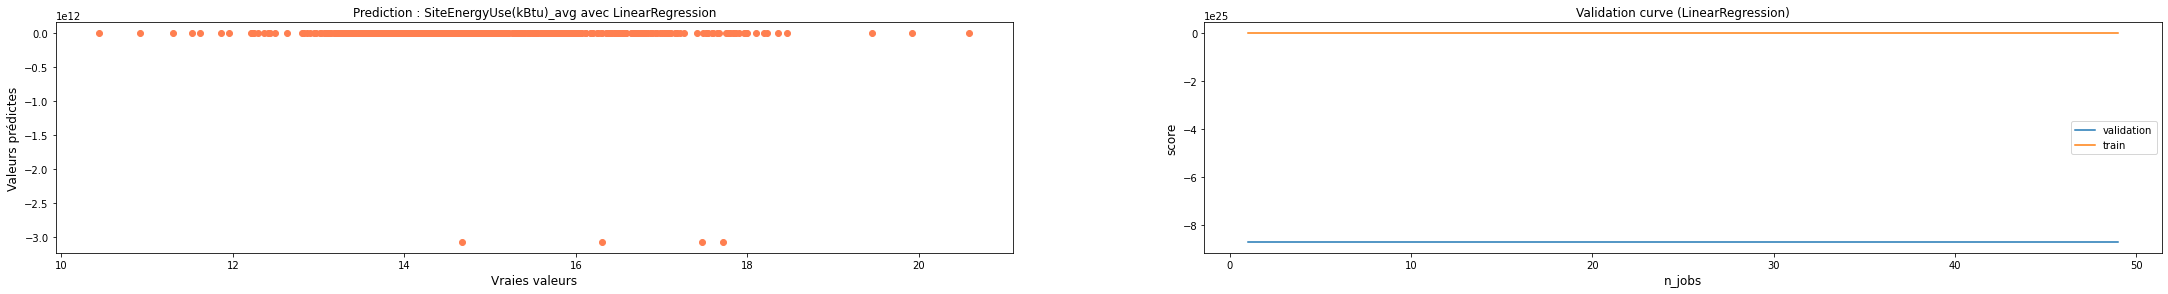

--------
Lasso
Score entrainement: -0.0009860999496147382
Cross: -0.0013825117928456532
MAE : 1.0785629289212049
MSE : 1.8824368817148918
RMSE : 1.3720192716266386


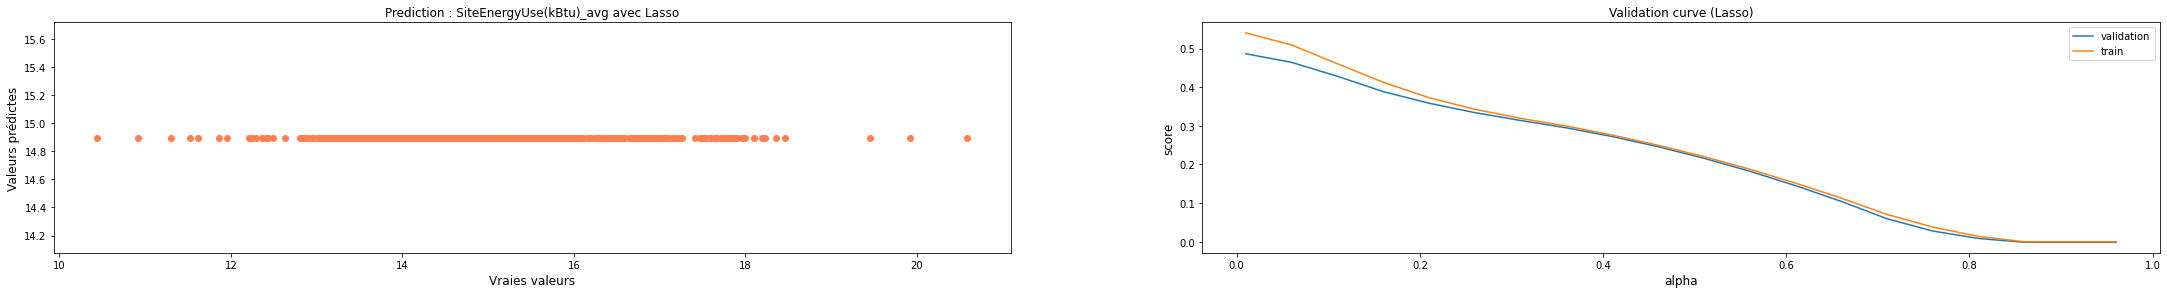

--------
Ridge
Score entrainement: -0.8752139359525284
Cross: 0.4931745194782412
MAE : 0.7783256273690752
MSE : 3.52649439819441
RMSE : 1.8778962692849703


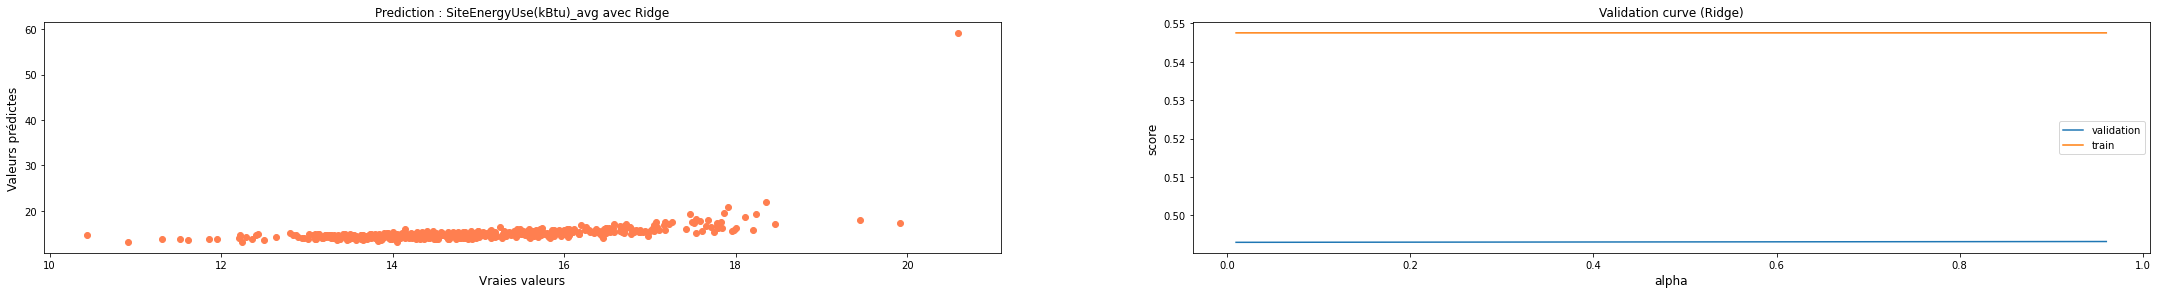

--------
ElasticNet
Score entrainement: 0.17256497813406324
Cross: 0.17769307723860356
MAE : 0.983105890717258
MSE : 1.556059771920319
RMSE : 1.247421248784996


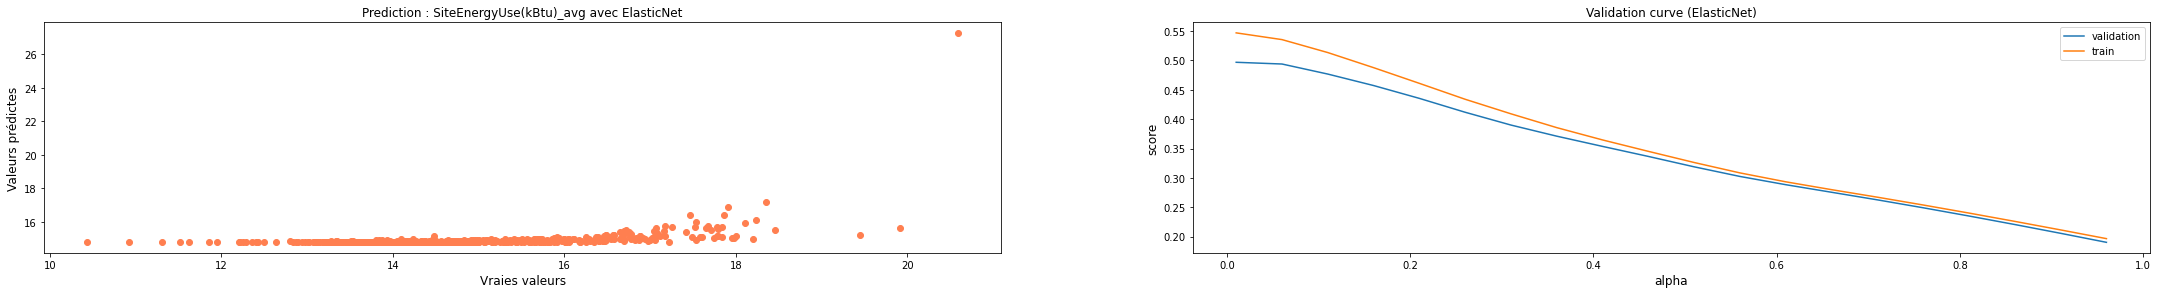

--------
RandomForestRegressor
Score entrainement: 0.6971134085947729
Cross: 0.655153984204404
MAE : 0.5463536783398275
MSE : 0.5696032049464101
RMSE : 0.7547206138342918


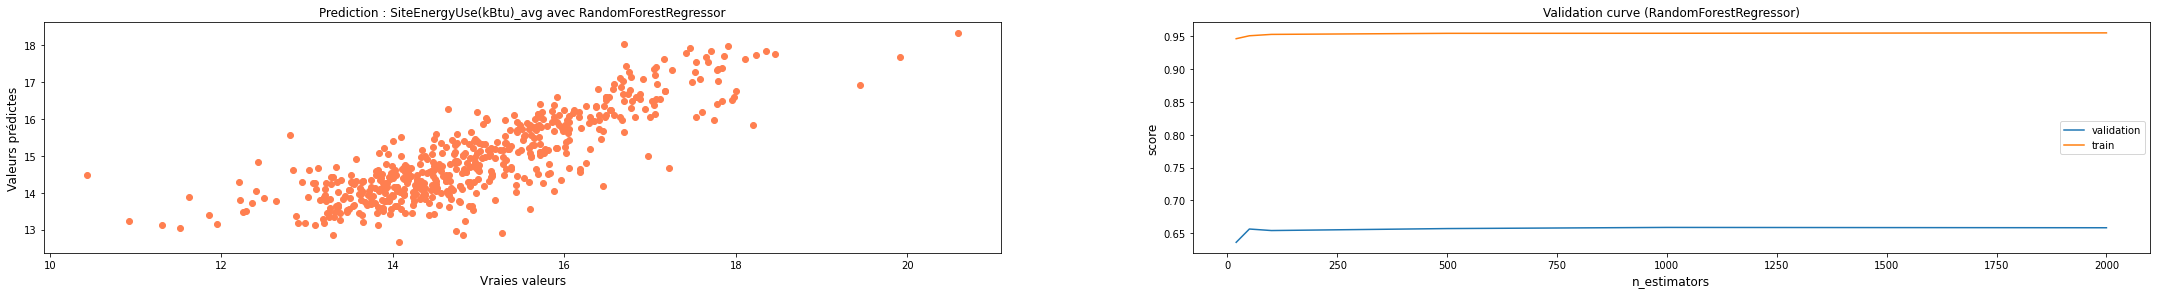

--------
XGBRegressor
Score entrainement: 0.705326931620272
Cross: 0.680936317612463
MAE : 0.5433158229705728
MSE : 0.5541569977785061
RMSE : 0.7444172202323815


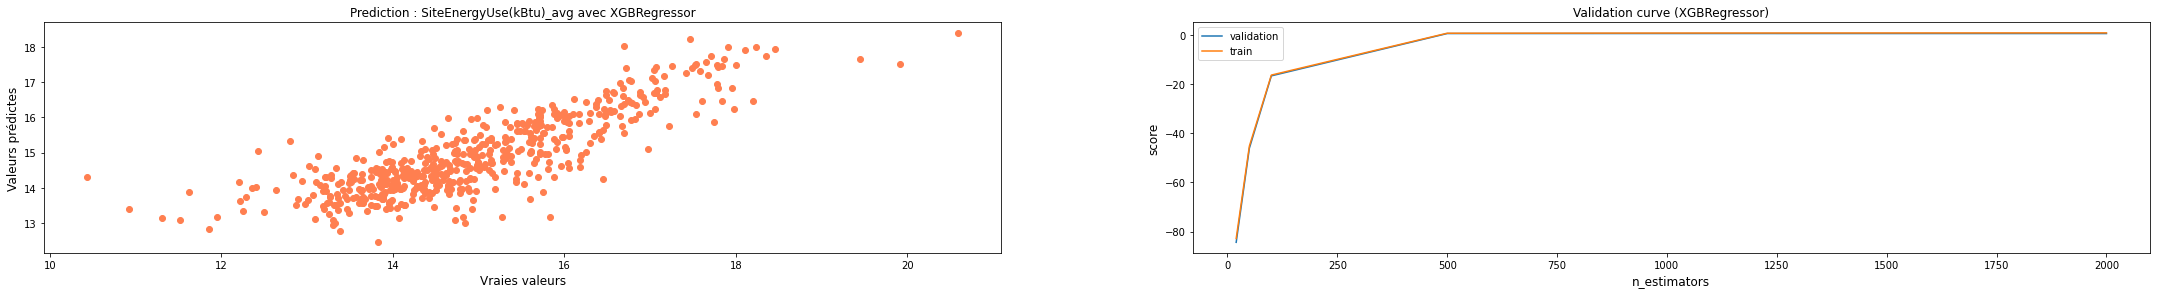

--------
SVR
Score entrainement: 0.623798318890569
Cross: 0.5905744944642852
MAE : 0.6209059973309003
MSE : 0.707478275192017
RMSE : 0.8411172779060105


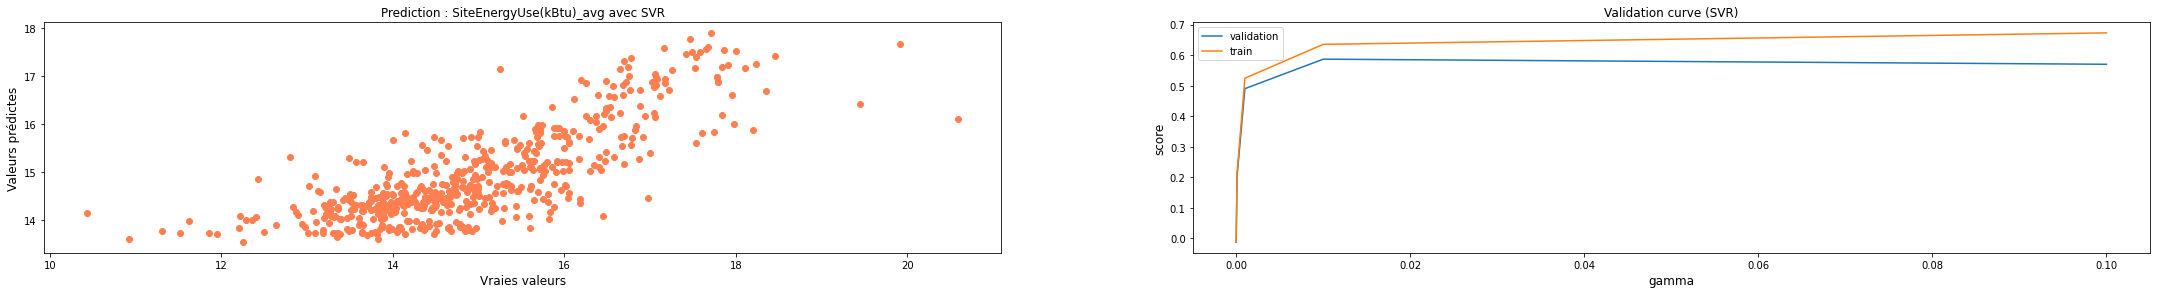

--------


In [75]:
df_energy = training_model(df[liste_train],Y['SiteEnergyUse(kBtu)_avg'], random_state=0)

#### Emissions
##### Scoring des différents modèles


LinearRegression
Score entrainement: -9.478024088731254e+22
Cross: -3.200737970967761e+26
MAE : 38065227359.17964
MSE : 2.014060200608204e+23
RMSE : 448782820594.5727


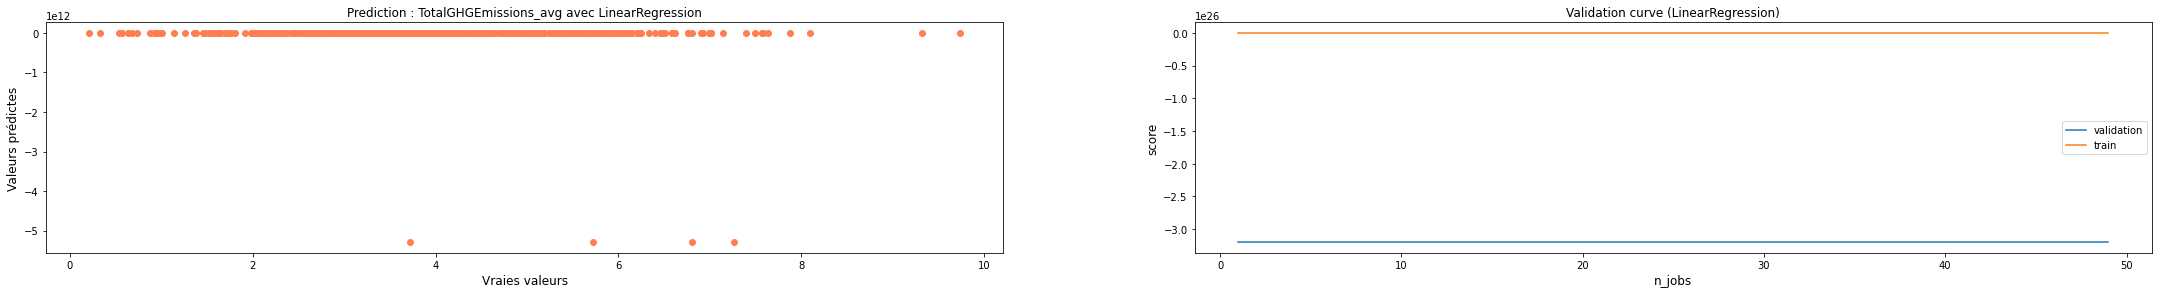

--------
Lasso
Score entrainement: -0.0002308643211774708
Cross: -0.004946718436804343
MAE : 1.1456394748457859
MSE : 2.1254695666413905
RMSE : 1.4578990248441044


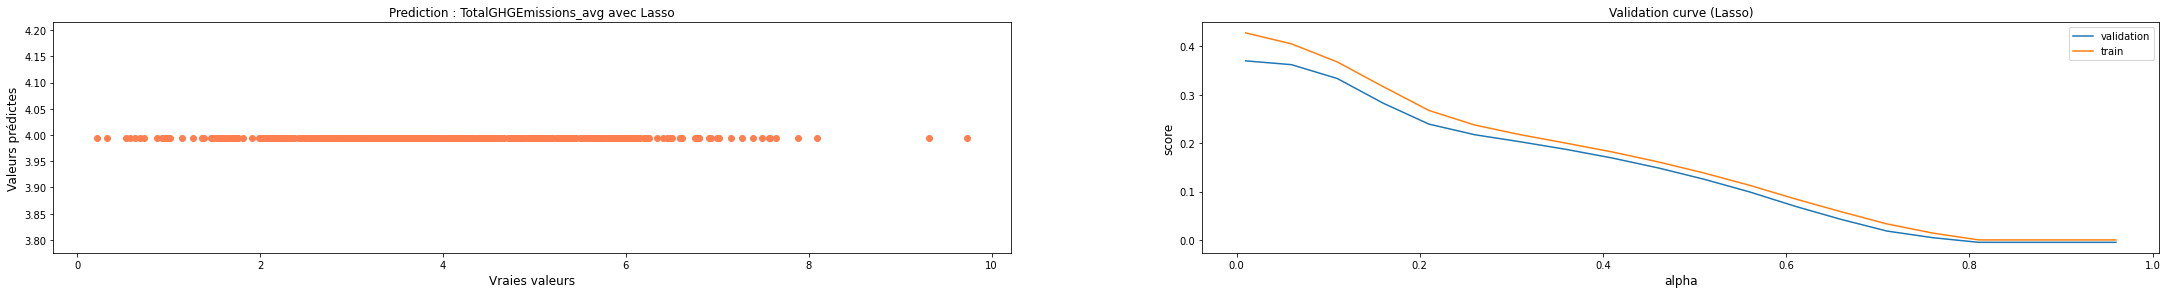

--------
Ridge
Score entrainement: -1.015805299212773
Cross: 0.37737761965636896
MAE : 0.9483240044335738
MSE : 4.283543898296878
RMSE : 2.0696724132811157


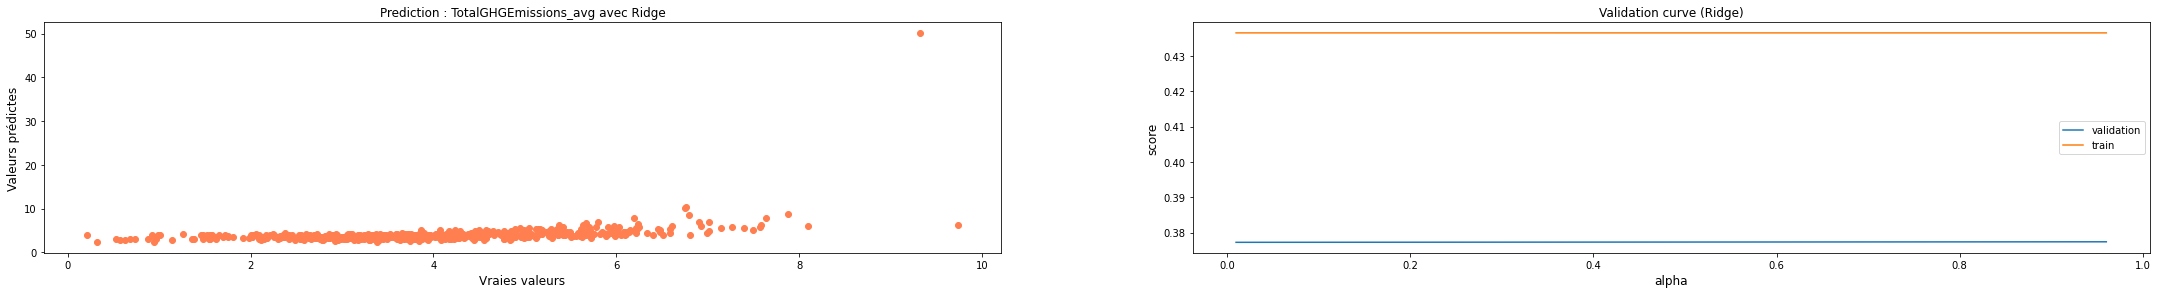

--------
ElasticNet
Score entrainement: 0.12203294152708344
Cross: 0.10093864935090335
MAE : 1.0733119781131704
MSE : 1.8656615486108794
RMSE : 1.365892217054801


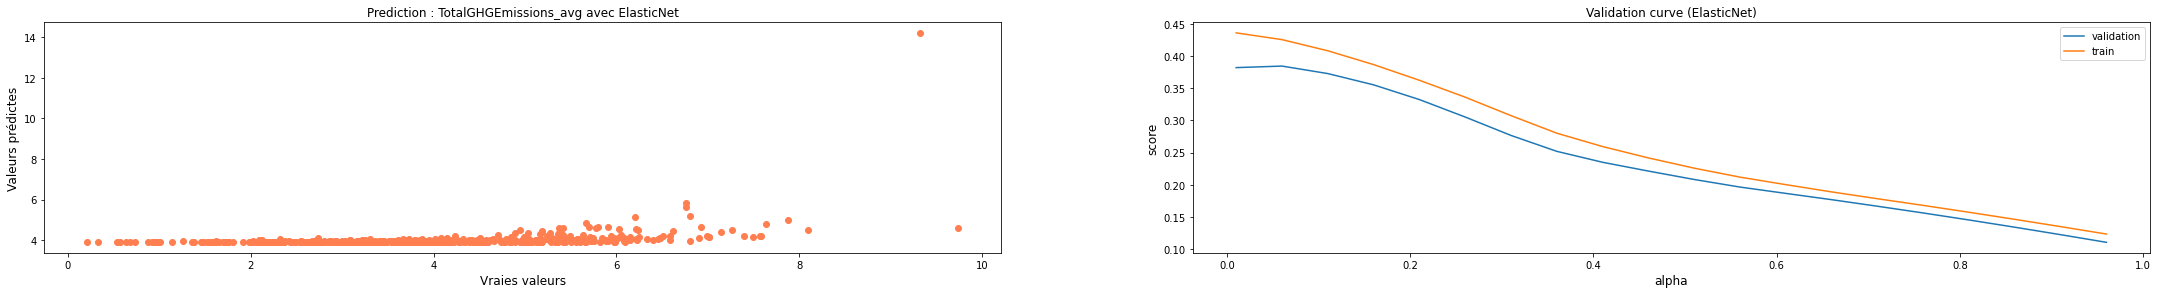

--------
RandomForestRegressor
Score entrainement: 0.5344820301347404
Cross: 0.4958343661097825
MAE : 0.7660582253496414
MSE : 0.9892159030153459
RMSE : 0.9945933354971498


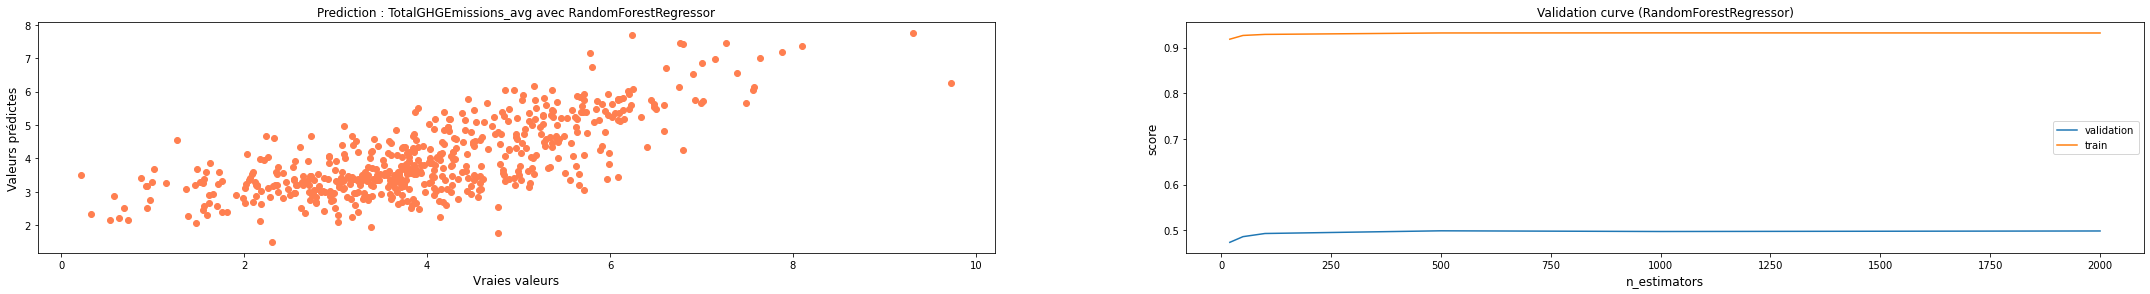

--------
XGBRegressor
Score entrainement: 0.528572600485526
Cross: 0.49452292816042986
MAE : 0.7874948777886338
MSE : 1.0017733168321428
RMSE : 1.0008862656826412


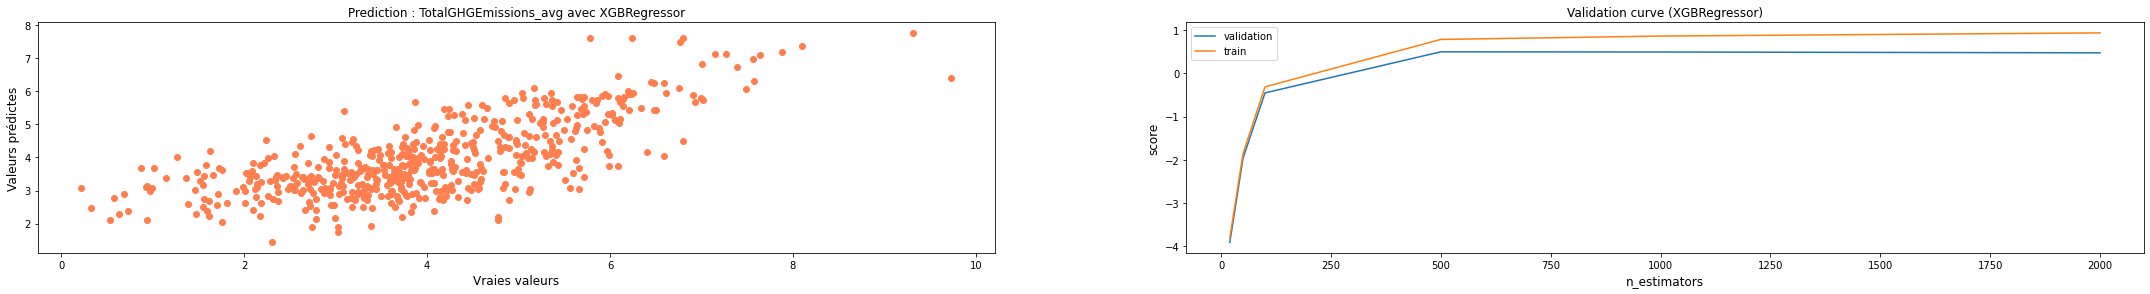

--------
SVR
Score entrainement: 0.4556822874380696
Cross: 0.4398380237702294
MAE : 0.8348389493165859
MSE : 1.1566637002542495
RMSE : 1.07548300788727


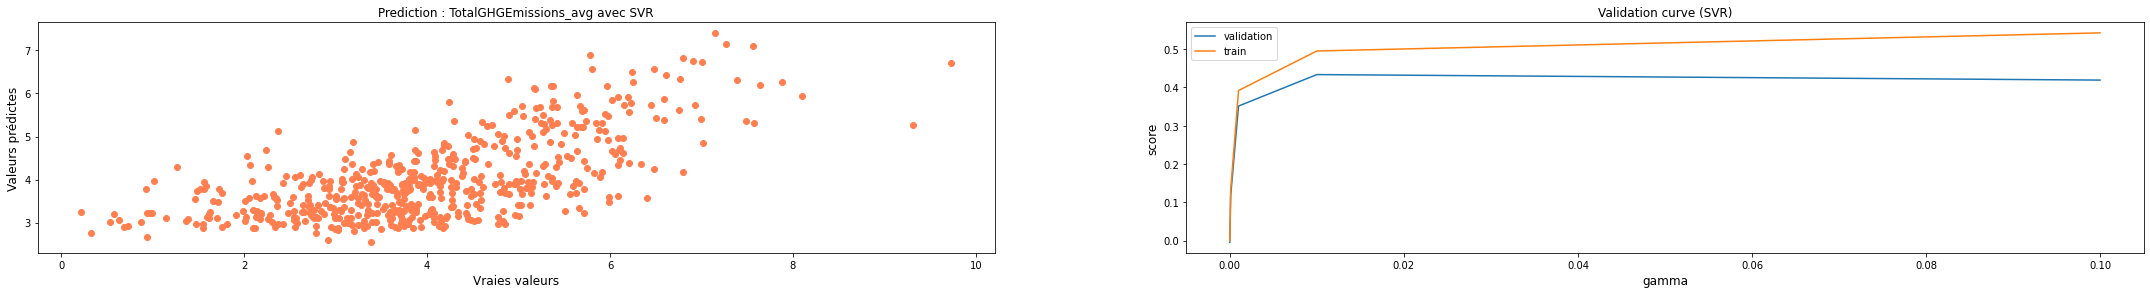

--------


In [76]:
df_ghg = training_model(df[liste_train], Y['TotalGHGEmissions_avg'], random_state=0)

## Modèle final

In [77]:
df_energy.set_index('Model')

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-36213510449718645227520.0,-87290537179074443597578240.0,22134703339.884274,68102491823162550910976.0,260964541313.877655
Lasso,-0.000986,-0.001383,1.078563,1.882437,1.372019
Ridge,-0.875214,0.493175,0.778326,3.526494,1.877896
ElasticNet,0.172565,0.177693,0.983106,1.55606,1.247421
RandomForestRegressor,0.697113,0.655154,0.546354,0.569603,0.754721
XGBRegressor,0.705327,0.680936,0.543316,0.554157,0.744417
SVR,0.623798,0.590574,0.620906,0.707478,0.841117


In [78]:
df_ghg.set_index('Model')

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-94780240887312535257088.0,-320073797096776102060228608.0,38065227359.179642,201406020060820398931968.0,448782820594.572693
Lasso,-0.000231,-0.004947,1.145639,2.12547,1.457899
Ridge,-1.015805,0.377378,0.948324,4.283544,2.069672
ElasticNet,0.122033,0.100939,1.073312,1.865662,1.365892
RandomForestRegressor,0.534482,0.495834,0.766058,0.989216,0.994593
XGBRegressor,0.528573,0.494523,0.787495,1.001773,1.000886
SVR,0.455682,0.439838,0.834839,1.156664,1.075483


<span style="color: #F00000"> Note : Augmenter le random_state augmente le score training, mais diminue la cross validation.</span>

### Choix de l'algorithme 
<span style="color: #26B260">On retient xgbscore qui affiche le meilleur score</span>

<span style="color: #FF7F00">Toutefois, nous allons optimiser les paramètres de RandomForestRegressor et SVR, qui affichait un score relativement proche. </span>

### Optimisation paramètres
#### Energy



In [79]:
# https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663 optimiser xgbregressor

# max_depth: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit.
# The value must be an integer greater than 0. Default is 6.

# learning_rate: The learning rate determines the step size at each iteration while your model optimizes toward its objective. 
# A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum.
# The value must be between 0 and 1. Default is 0.3.

# n_estimators: The number of trees in our ensemble. Equivalent to the number of boosting rounds.
# The value must be an integer greater than 0. Default is 100.
# NB: In the standard library, this is referred as num_boost_round.

Y_target = Y['SiteEnergyUse(kBtu)_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df[liste_train],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

def objective_energy(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    # Au départ, il y avait une fonction par modèle, mais ce n'était pas vraiment pas opti...

    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])
    
                   
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation


study_energy= optuna.create_study(direction="maximize", study_name="optimisation_ML_energy", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_energy.optimize(objective_energy, n_trials=5, show_progress_bar=True, n_jobs=-1) # dû au n_jobs=-1, il en fait parfois un peu plus que 150

# pour ouvrir une study recente : loaded_study = optuna.load_study(study_name="my_study", storage="sqlite:///example.db")

[I 2022-12-01 15:05:00,211] Using an existing study with name 'optimisation_ML_energy' instead of creating a new one.
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-12-01 15:05:14,831] Trial 600 finished with value: 0.6727370288372001 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 909, 'learning_rate': 0.02, 'max_depth': 7}. Best is trial 425 with value: 0.6843739291882716.
[I 2022-12-01 15:05:15,026] Trial 601 finished with value: 0.6727370288372001 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 909, 'learning_rate': 0.02, 'max_depth': 7}. Best is trial 425 with value: 0.6843739291882716.
[I 2022-12-01 15:05:15,131] Trial 602 finished with value: 0.6728630611285371 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 906, 'learning_rate': 0.02, 'max_depth': 7}. Best is trial 425 with value: 0.6843739291882716

In [80]:
trial_energy = study_energy.best_trial
print(f'cross_validation : {trial_energy.value}')
print(f'Meilleurs hyperparamètres : {trial_energy.params}')

# cross_validation : 0.6848082622855352
# Meilleurs hyperparamètres : {'n_estimators': 247, 'learning_rate': 0.03, 'max_depth': 7}

# cross_validation : 0.6842875863460688
# Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 877}


cross_validation : 0.6843739291882716
Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 853}


In [81]:
optuna.visualization.plot_optimization_history(study_energy)

#### GHG


In [82]:
Y_target = Y['TotalGHGEmissions_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df[liste_train],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)



ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

def objective_ghg(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])                    
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation

# La fonction prend du temps... on va donc stocker les résultats dans une db et la charger si besoin ! On passera évidemment le load_if_exists en False s'il y a des changements dans les étapes précédentes.
study_ghg = optuna.create_study(direction="maximize", study_name="optimisation_ML_ghg", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_ghg.optimize(objective_ghg, n_trials=5, n_jobs=-1)

[I 2022-12-01 15:05:15,532] Using an existing study with name 'optimisation_ML_ghg' instead of creating a new one.
[I 2022-12-01 15:05:22,783] Trial 547 finished with value: 0.49641314651206053 and parameters: {'classifier': 'RandomForest', 'n_estimators': 152, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-12-01 15:05:23,670] Trial 546 finished with value: 0.5014154787925842 and parameters: {'classifier': 'RandomForest', 'n_estimators': 373, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-12-01 15:05:24,552] Trial 545 finished with value: 0.4984474219060292 and parameters: {'classifier': 'RandomForest', 'n_estimators': 423, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-12-01 15:05:25,969] Trial 548 finished with value: 0.5025231682475496 and parameters: {'classifier': 'RandomForest', 'n_estimators': 364, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-12-01 15:05:25,985] Tria

In [83]:
trial_ghg = study_ghg.best_trial
print(f'cross_validation : {trial_ghg.value}')
print(f'Meilleurs hyperparamètres : {trial_ghg.params}')

cross_validation : 0.504268011977552
Meilleurs hyperparamètres : {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 392}


## Resultat final

### Energy

In [84]:
classifier_energy, model_energy = predict_optuna(df[liste_train], Y['SiteEnergyUse(kBtu)_avg'], trial_energy)

df['Energy_predict_log'] = model_energy.predict(df[liste_train])
df['Energy_predict'] = np.exp(df['Energy_predict_log'])

0.7073019849829378
0.6844539453438111


### GHG

In [85]:
classifier_ghg, model_ghg = predict_optuna(df[liste_train], Y['TotalGHGEmissions_avg'], trial_ghg)

df['GHG_predict_log'] = model_ghg.predict(df[liste_train])
df['GHG_predict'] = np.exp(df['GHG_predict_log'])

0.5413010781189418
0.5016676852946358


## Features importance

In [86]:
liste_features = list(numerical_columns) + list(ohe.get_feature_names_out(categorical_columns))

### Energy

In [87]:
fig = feature_importance(model=model_energy, classifier=classifier_energy, index=liste_features)
fig.show()


### GHG

In [88]:
fig = feature_importance(model=model_ghg, classifier=classifier_ghg, index=liste_features)
fig.show()


## Comparaison résultat réel et prédictions

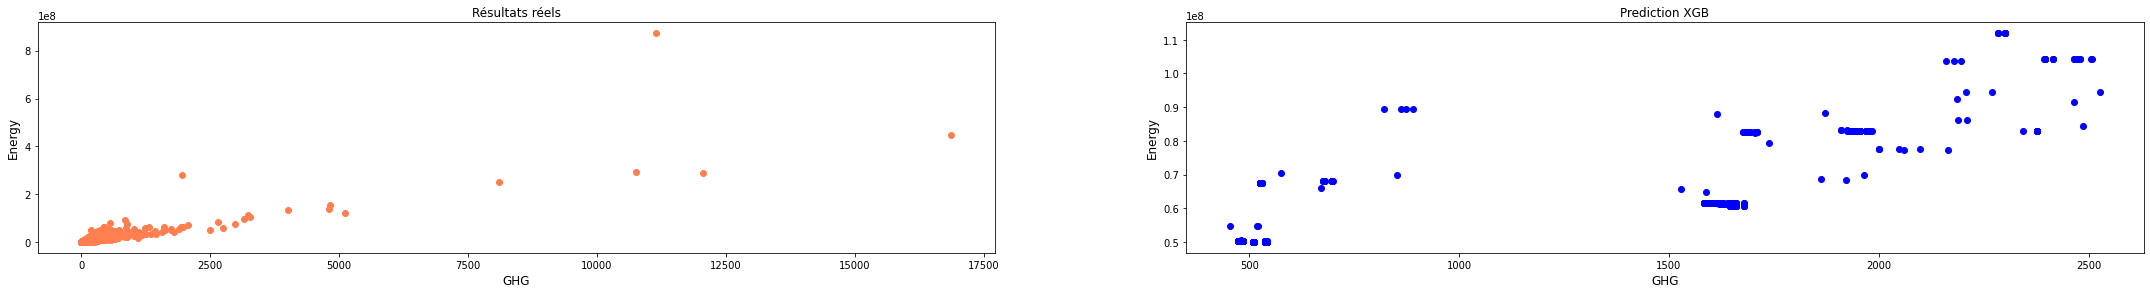

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
        
ax1.scatter(df['TotalGHGEmissions_avg'], df['SiteEnergyUse(kBtu)_avg'], c='coral')
ax1.set_title(f'Résultats réels')
ax1.set_xlabel("GHG", size = 12)
ax1.set_ylabel("Energy", size = 12)
        
ax2.scatter(df['GHG_predict'], df['Energy_predict'], c='b')
ax2.set_title(f'Prediction XGB')
ax2.set_xlabel("GHG", size = 12)
ax2.set_ylabel("Energy", size = 12)     

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

plt.show()

In [90]:
df[(df['TotalGHGEmissions_avg'] - df['GHG_predict'])> 2000]

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,25,26,27,28,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Energy_predict_log,Energy_predict,GHG_predict_log,GHG_predict
34,43,Campus,1.0,3.0,47.534930,-122.317880,Office,494835.0,0.0,494835.0,...,0.0,0.0,0.0,0.0,19.921163,9.733350,18.028715,67572736.0,6.265038,525.861822
121,198,NonResidential,6.0,10.0,47.662310,-122.281460,Hospital (General Medical & Surgical),879000.0,0.0,879000.0,...,0.0,0.0,0.0,0.0,19.346970,8.999139,18.163305,77307792.0,7.680692,2166.119234
163,268,NonResidential,6.0,5.0,47.607050,-122.309660,Hospital (General Medical & Surgical),597519.0,0.0,597519.0,...,0.0,0.0,0.0,0.0,18.760927,8.479674,18.165152,77450656.0,7.648667,2097.846275
166,276,NonResidential,9.0,8.0,47.603990,-122.323770,Hospital (General Medical & Surgical),1158691.0,0.0,1158691.0,...,0.0,0.0,0.0,0.0,19.500626,9.283368,18.064203,70013824.0,7.583132,1964.772796
334,477,Campus,1.0,5.0,47.628550,-122.330350,Other,535947.0,97641.5,438305.5,...,0.0,0.0,0.0,0.0,18.711914,8.299159,17.936543,61622796.0,7.367884,1584.277265
607,828,NonResidential,7.0,14.0,47.608951,-122.322402,Hospital (General Medical & Surgical),1765970.0,0.0,1765970.0,...,0.0,0.0,0.0,0.0,19.482456,9.398149,18.041502,68442320.0,7.561168,1922.089109
1627,49859,Campus,7.0,4.0,47.628112,-122.374265,Other,808520.0,376000.0,432520.0,...,0.0,0.0,0.0,0.0,18.875612,8.482573,18.043348,68568808.0,7.529702,1862.551101
1638,49940,NonResidential,1.0,8.0,47.609860,-122.327740,Hospital (General Medical & Surgical),374466.0,0.0,374466.0,...,0.0,0.0,0.0,0.0,18.613769,8.539436,17.934696,61509128.0,7.412821,1657.093976
1643,49967,Campus,111.0,0.0,47.656440,-122.310410,Education,9320156.0,0.0,9320156.0,...,0.0,0.0,0.0,0.0,20.588504,9.318348,18.250954,84389512.0,7.818648,2486.542143


In [91]:
df[(df['SiteEnergyUse(kBtu)_avg'] - df['Energy_predict'])> 5000000]
# essayer d'expliquer d'où viennent les écarts (les batiments ont-ils des points communs ?)
# suivent-ils une loi normale ? Un type de batiment en particulier ?

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,25,26,27,28,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Energy_predict_log,Energy_predict,GHG_predict_log,GHG_predict
2,3,NonResidential,1.0,41.0,47.613930,-122.338100,Hotel/Senior Care/Housing,959050.0,98359.0,860691.0,...,0.0,0.0,0.0,0.0,18.104034,7.637900,17.923212,60806788.0,7.413879,1658.848866
34,43,Campus,1.0,3.0,47.534930,-122.317880,Office,494835.0,0.0,494835.0,...,0.0,0.0,0.0,0.0,19.921163,9.733350,18.028715,67572736.0,6.265038,525.861822
48,63,NonResidential,1.0,34.0,47.610870,-122.333390,Hotel/Senior Care/Housing,994212.0,146694.0,847518.0,...,0.0,0.0,0.0,0.0,18.233309,7.881871,17.923212,60806788.0,7.406109,1646.009327
121,198,NonResidential,6.0,10.0,47.662310,-122.281460,Hospital (General Medical & Surgical),879000.0,0.0,879000.0,...,0.0,0.0,0.0,0.0,19.346970,8.999139,18.163305,77307792.0,7.680692,2166.119234
163,268,NonResidential,6.0,5.0,47.607050,-122.309660,Hospital (General Medical & Surgical),597519.0,0.0,597519.0,...,0.0,0.0,0.0,0.0,18.760927,8.479674,18.165152,77450656.0,7.648667,2097.846275
166,276,NonResidential,9.0,8.0,47.603990,-122.323770,Hospital (General Medical & Surgical),1158691.0,0.0,1158691.0,...,0.0,0.0,0.0,0.0,19.500626,9.283368,18.064203,70013824.0,7.583132,1964.772796
226,357,Nonresidential COS,1.0,63.0,47.605010,-122.329880,Office,1275187.0,159600.0,1115587.0,...,0.0,0.0,0.0,0.0,17.960959,6.088398,17.725838,49915280.0,6.291726,540.084590
267,402,NonResidential,1.0,46.0,47.610540,-122.334660,Office,1536606.0,512608.0,1023998.0,...,0.0,0.0,0.0,0.0,17.844606,6.273707,17.725838,49915280.0,6.295074,541.895938
279,415,NonResidential,1.0,30.0,47.610220,-122.337450,Office,755000.0,134662.0,620338.0,...,0.0,0.0,0.0,0.0,17.835047,6.924750,17.725838,49915280.0,6.293716,541.160579
303,440,NonResidential,1.0,6.0,47.619150,-122.348570,Parking,213834.0,104922.0,108912.0,...,0.0,0.0,0.0,0.0,18.197879,6.336640,17.936543,61622796.0,7.393667,1625.657005


# Prediction avec Energystar
Maintenant que nous avons fini avec notre data, nous allons refaire les mêmes étapes avec le energystar.
## Séparation des types de variable

In [92]:
# Séparation des types de variables...

categorical_columns_star = df_filtre_categorical(df_energystar)
numerical_columns_star = df_filtre_numerical(df_energystar)

## Variables object

In [93]:
# on encode les variables catégoriques...

ohe_star, df_ohe_star = df_encodage_categorie(df_energystar, categorical_columns_star)

# # On réinitialise l'index pour que ça colle avec le df_ohe
df_energystar.reset_index(drop=True, inplace=True)

df_energystar[df_ohe_star.columns.values] = df_ohe_star

## Variables Y

In [94]:
# on sépare les variables Y
Y_star = ['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']
Y_star = df_energystar[Y_star]
Y_star

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,7.103895e+06,249.705
1,8.371084e+06,279.685
2,7.285884e+07,2075.380
3,1.751195e+07,1111.385
4,1.450085e+07,506.355
...,...,...
1102,4.420650e+06,134.800
1103,1.325973e+06,9.240
1104,5.026677e+05,3.500
1105,3.878100e+05,7.790


In [95]:
# On sait via df que la distribution n'est pas normale, donc on applique un log

Y_star = np.log(1+Y_star)
df_energystar[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']] = np.log(df_energystar[['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']]) 
Y_star

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,15.776154,5.524277
1,15.940294,5.637233
2,18.104034,7.638381
3,16.678394,7.014262
4,16.489718,6.229211
...,...,...
1102,15.301798,4.911183
1103,14.097658,2.326302
1104,13.127687,1.504077
1105,12.868273,2.173615


In [96]:
liste_train_star = numerical_columns_star.tolist() + df_ohe_star.columns.values.tolist()

## Modèle final

### Energy

LinearRegression
Score entrainement: -1.1549686721611688e+23
Cross: 0.6111231203695062
MAE : 29353275227.635567
MSE : 1.78987666676177e+23
RMSE : 423069340269.62646


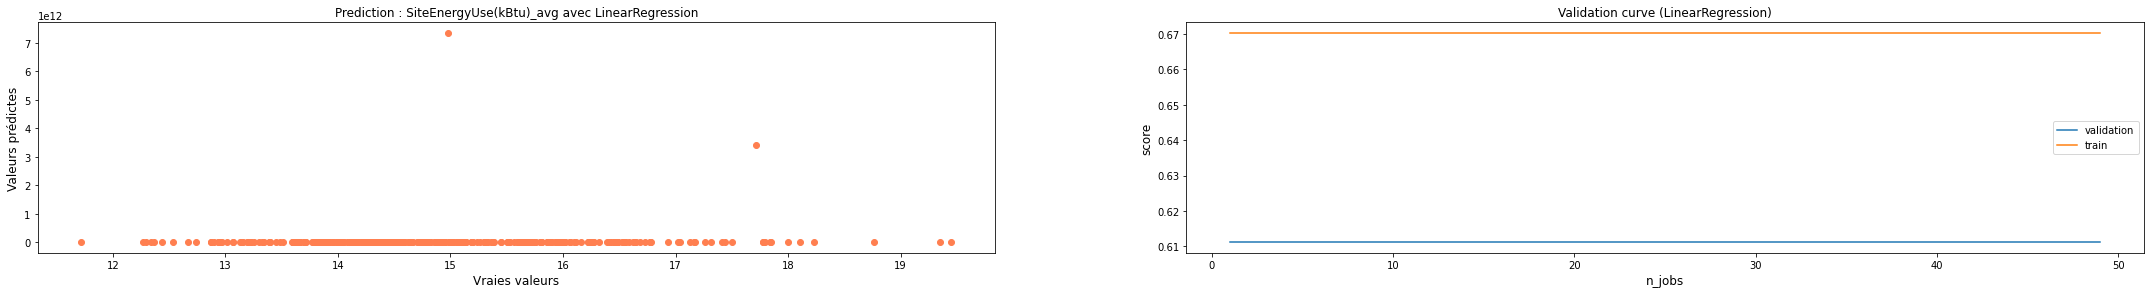

--------
Lasso
Score entrainement: -0.012122898144603544
Cross: -0.030673337729696337
MAE : 1.0038187321560592
MSE : 1.568505885007703
RMSE : 1.2524000499072583


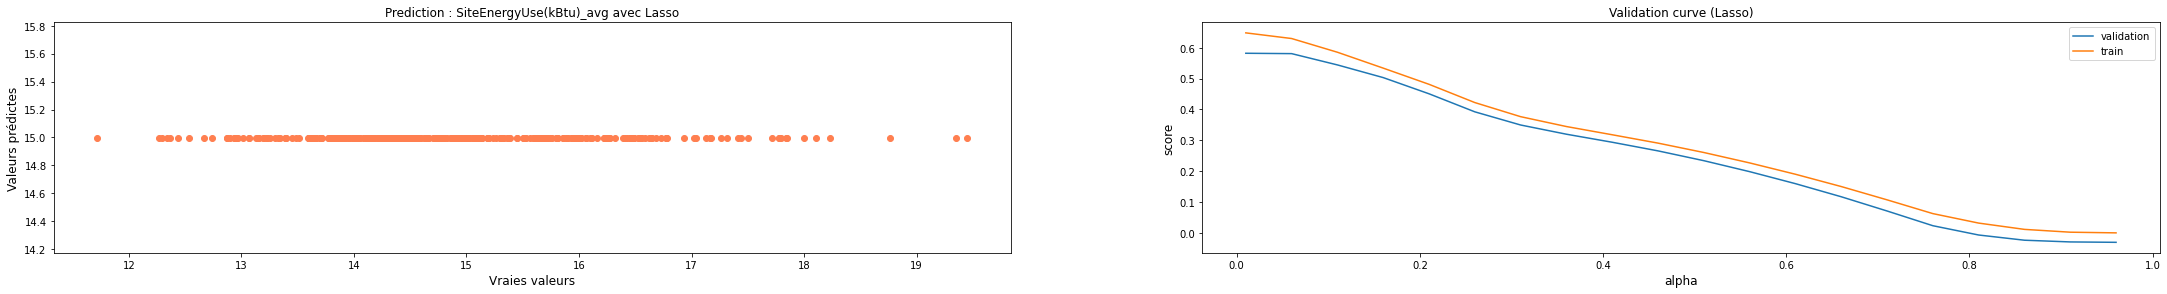

--------
Ridge
Score entrainement: 0.6943880539943911
Cross: 0.6109355914493726
MAE : 0.5478624157529703
MSE : 0.47361257878583024
RMSE : 0.6881951603911715


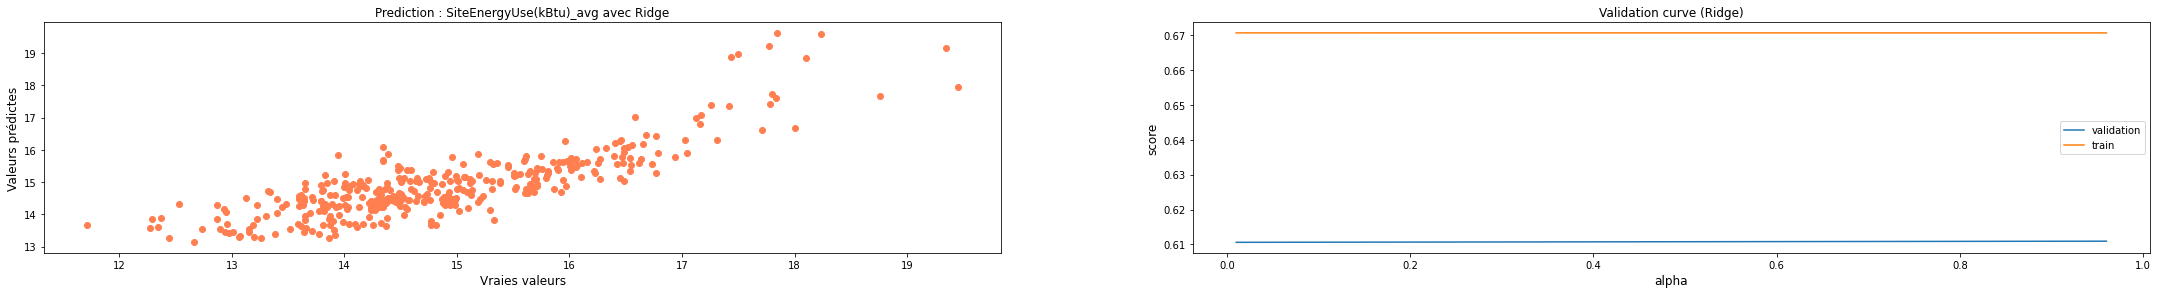

--------
ElasticNet
Score entrainement: 0.2256849436656383
Cross: 0.19165117622466737
MAE : 0.8895290895637803
MSE : 1.1999706013340263
RMSE : 1.0954316963343842


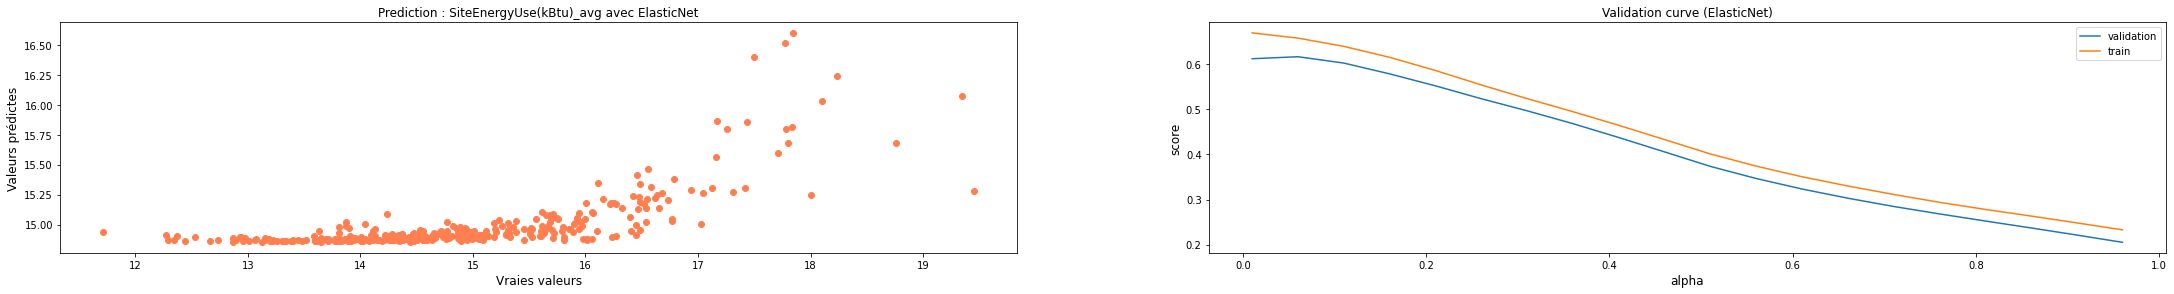

--------
RandomForestRegressor
Score entrainement: 0.8335692302345926
Cross: 0.8103191773887943
MAE : 0.34251659099504655
MSE : 0.2579208931069033
RMSE : 0.5078591272261466


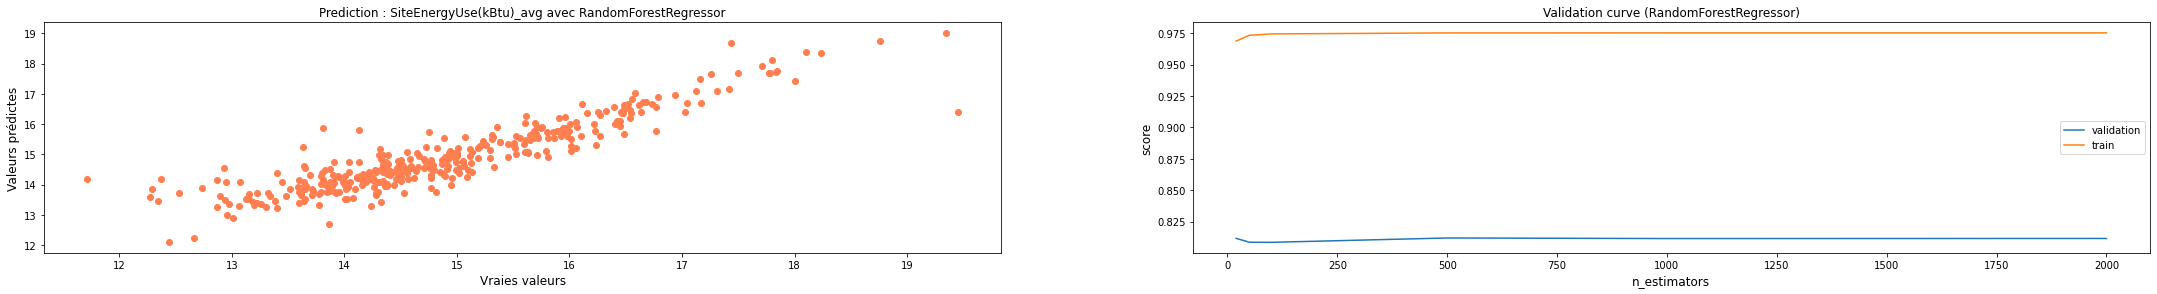

--------
XGBRegressor
Score entrainement: 0.8534047985177147
Cross: 0.8445245160579947
MAE : 0.3360076904078346
MSE : 0.2271813399937557
RMSE : 0.47663543719886764


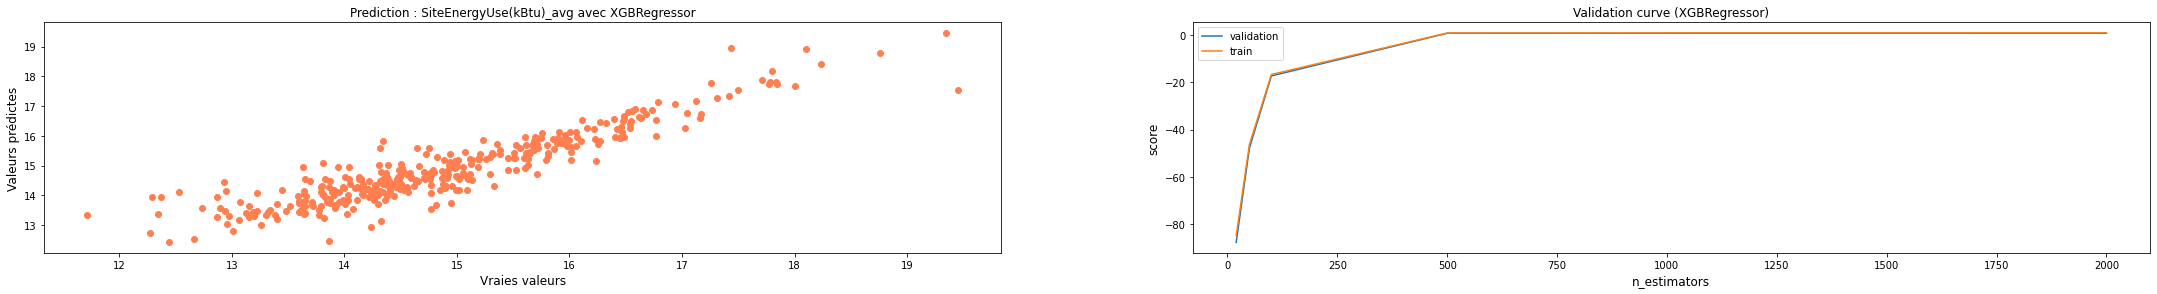

--------
SVR
Score entrainement: 0.7434007375968117
Cross: 0.7194967877449994
MAE : 0.4341648390390907
MSE : 0.3976567014794818
RMSE : 0.6306002707575392


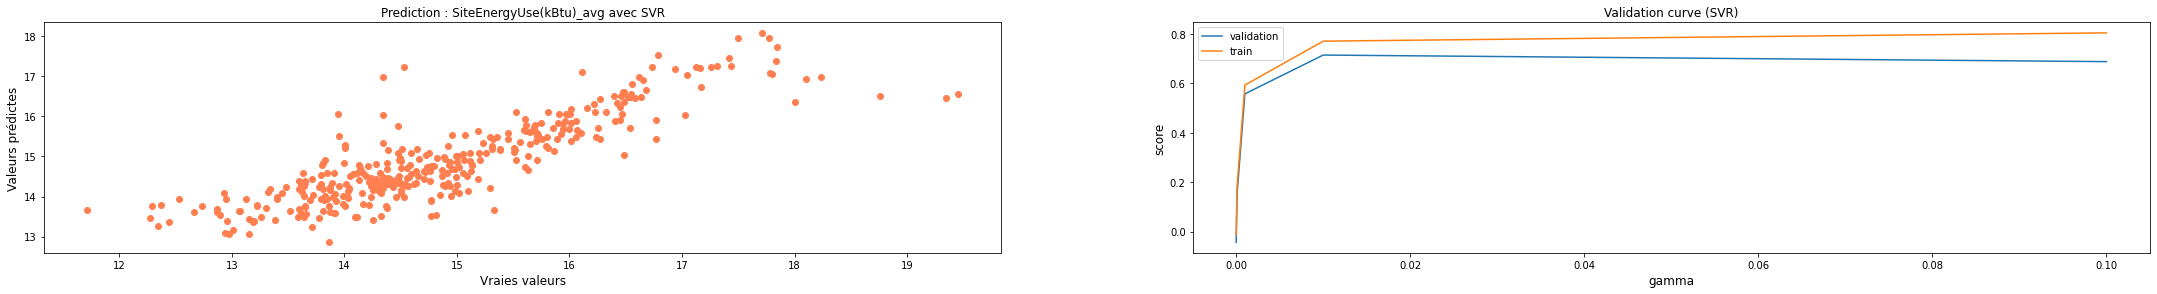

--------


In [97]:
df_energy_star = training_model(df_energystar[liste_train_star], Y_star['SiteEnergyUse(kBtu)_avg'], random_state=0)

### GHG

LinearRegression
Score entrainement: -5.304746856073215e+20
Cross: 0.4194716551985981
MAE : 2240177754.027454
MSE : 1.0424972863822675e+21
RMSE : 32287726559.518982


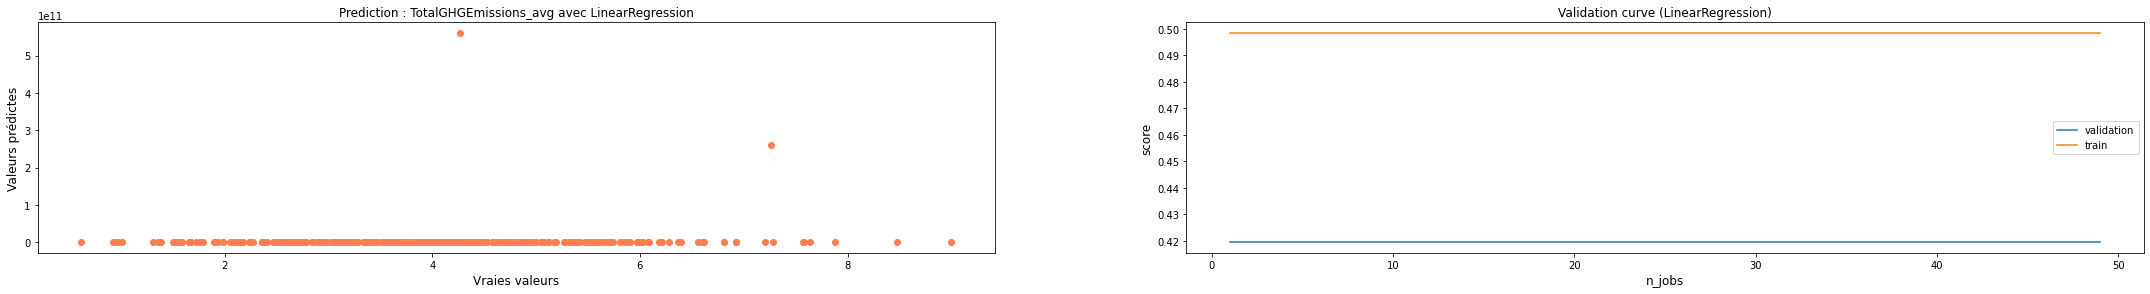

--------
Lasso
Score entrainement: -0.008681940811679167
Cross: -0.030533313850710543
MAE : 1.1072711218679587
MSE : 1.98227778751609
RMSE : 1.4079338718548147


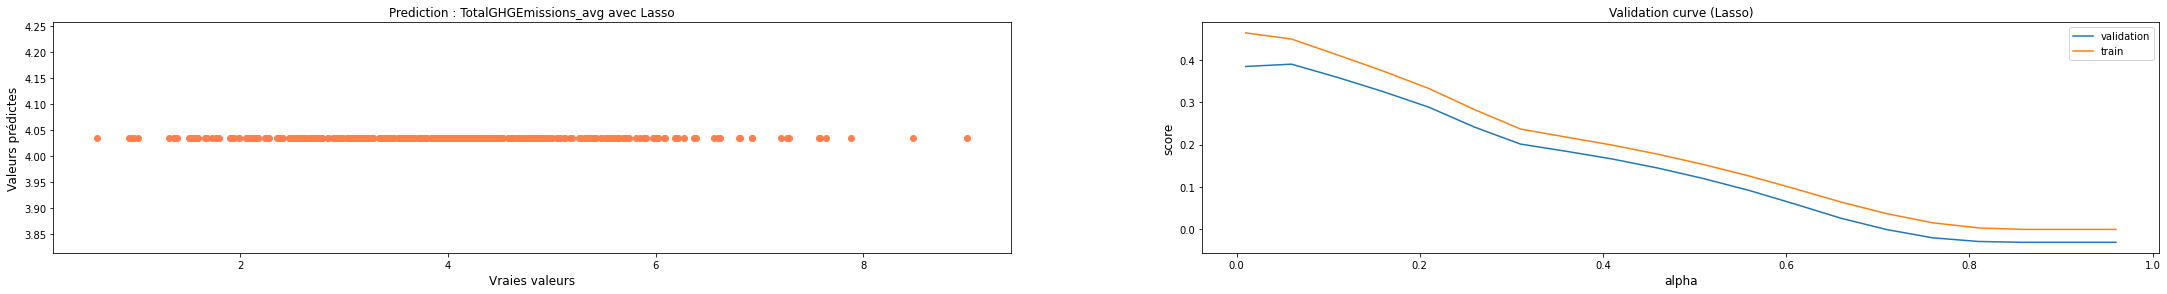

--------
Ridge
Score entrainement: 0.527285907372665
Cross: 0.4183165382527916
MAE : 0.7733184092484239
MSE : 0.9289852506994937
RMSE : 0.9638388095005791


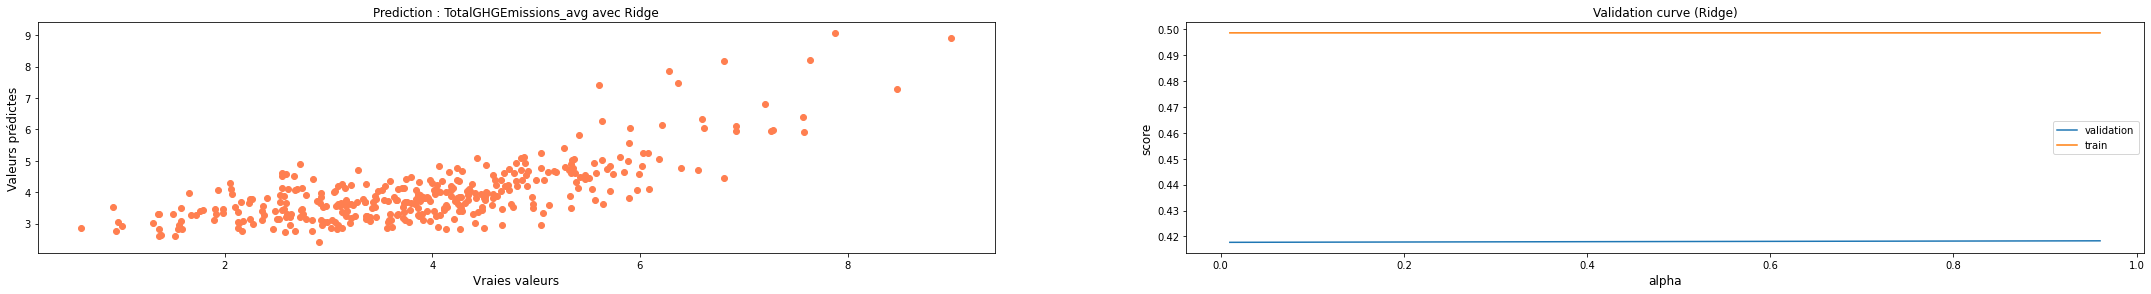

--------
ElasticNet
Score entrainement: 0.12344901206620662
Cross: 0.09197527412714243
MAE : 1.0377473241284403
MSE : 1.7226119381182086
RMSE : 1.31248311917457


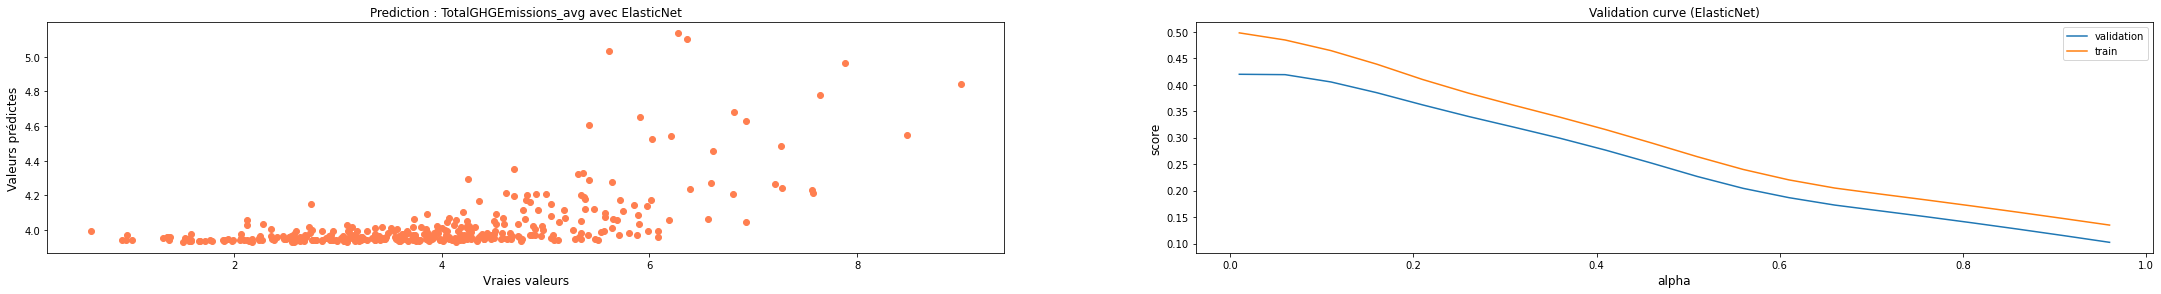

--------
RandomForestRegressor
Score entrainement: 0.6398488862054001
Cross: 0.5957581860449828
MAE : 0.6630690272862289
MSE : 0.7077746950140982
RMSE : 0.841293465453107


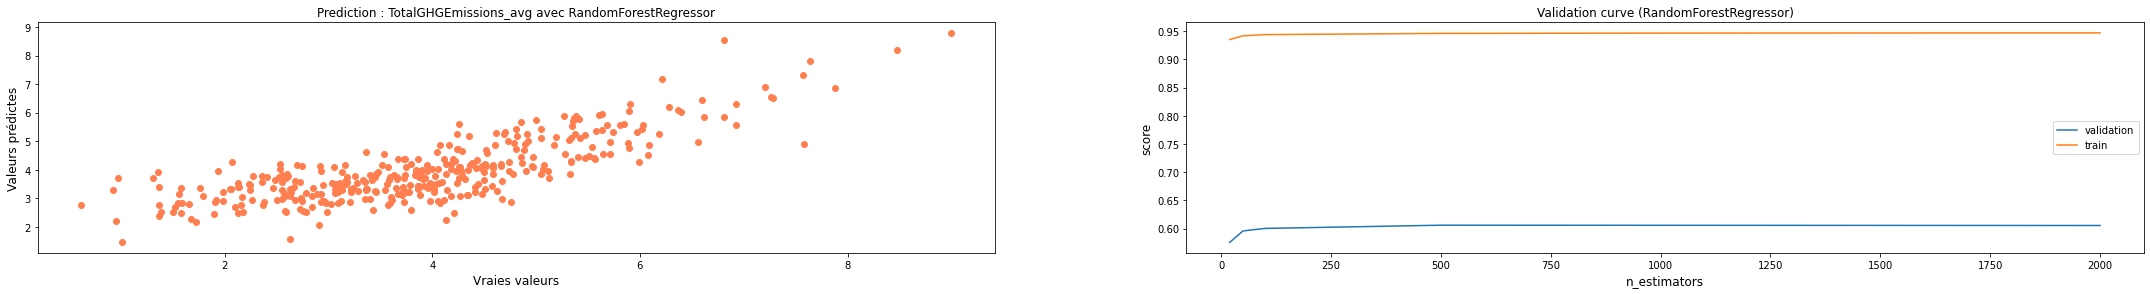

--------
XGBRegressor
Score entrainement: 0.6285959612167928
Cross: 0.59150341709297
MAE : 0.6735165845262314
MSE : 0.7298891221164129
RMSE : 0.85433548569424


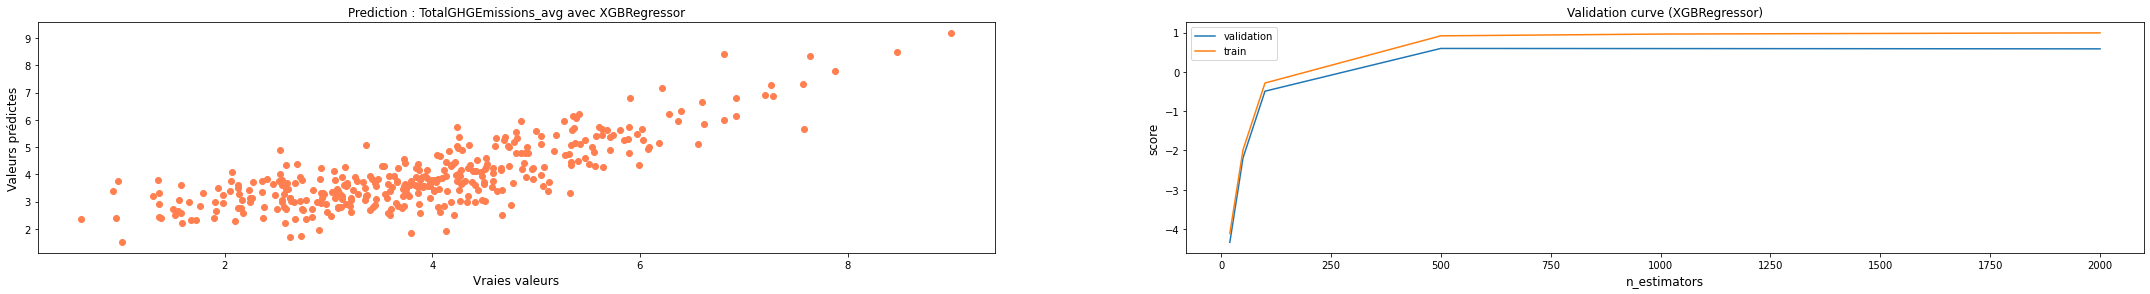

--------
SVR
Score entrainement: 0.5217760088653001
Cross: 0.481567131337988
MAE : 0.7297663004860071
MSE : 0.9398133908502221
RMSE : 0.9694397303856604


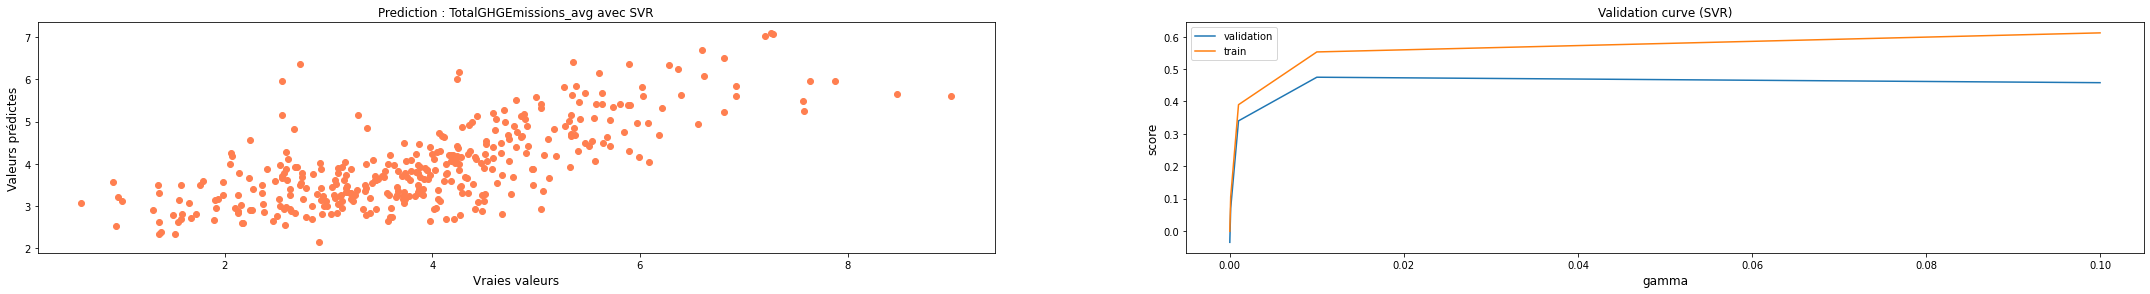

--------


In [98]:
df_ghg_star = training_model(df_energystar[liste_train_star], Y_star['TotalGHGEmissions_avg'], random_state=0)

## Optimisation paramètres
Même étape...
### Energy


In [99]:
Y_target = Y_star['SiteEnergyUse(kBtu)_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df_energystar[liste_train_star],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)



ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

def objective_energy_star(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    # Au départ, il y avait une fonction par modèle, mais ce n'était pas vraiment pas opti...

    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])
    
                   
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation


study_energy_star= optuna.create_study(direction="maximize", study_name="optimisation_ML_energy_star", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_energy_star.optimize(objective_energy_star, n_trials=5, n_jobs=-1) # dû au n_jobs=-1, il en fait parfois un peu plus que 150

[I 2022-12-01 15:06:42,924] Using an existing study with name 'optimisation_ML_energy_star' instead of creating a new one.
[I 2022-12-01 15:06:45,150] Trial 309 finished with value: 0.8480826982872015 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 205, 'learning_rate': 0.060000000000000005, 'max_depth': 5}. Best is trial 222 with value: 0.8481962909442459.
[I 2022-12-01 15:06:45,615] Trial 305 finished with value: 0.8483932198028128 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 295, 'learning_rate': 0.060000000000000005, 'max_depth': 5}. Best is trial 305 with value: 0.8483932198028128.
[I 2022-12-01 15:06:45,681] Trial 307 finished with value: 0.8483595158510095 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 291, 'learning_rate': 0.060000000000000005, 'max_depth': 5}. Best is trial 305 with value: 0.8483932198028128.
[I 2022-12-01 15:06:45,702] Trial 308 finished with value: 0.8483431082073215 and parameters: {'classifier': 'XGBRegresso

In [100]:
trial_energy_star = study_energy_star.best_trial
print(f'cross_validation : {trial_energy_star.value}')
print(f'Meilleurs hyperparamètres : {trial_energy_star.params}')

cross_validation : 0.8483932198028128
Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.060000000000000005, 'max_depth': 5, 'n_estimators': 295}


### GHG

In [101]:
Y_target = Y_star['TotalGHGEmissions_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df_energystar[liste_train_star],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)


ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

def objective_ghg_star(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])                    
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation

# La fonction prend du temps... on va donc stocker les résultats dans une db et la charger si besoin ! On passera évidemment le load_if_exists en False s'il y a des changements dans les étapes précédentes.
study_ghg_star = optuna.create_study(direction="maximize", study_name="optimisation_ML_ghg_star", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_ghg_star.optimize(objective_ghg_star, n_trials=5, n_jobs=-1)

[I 2022-12-01 15:06:45,880] Using an existing study with name 'optimisation_ML_ghg_star' instead of creating a new one.
[I 2022-12-01 15:06:54,944] Trial 305 finished with value: 0.6040332359865173 and parameters: {'classifier': 'RandomForest', 'n_estimators': 187, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-12-01 15:06:56,199] Trial 308 finished with value: 0.6027810970901802 and parameters: {'classifier': 'RandomForest', 'n_estimators': 188, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-12-01 15:07:08,412] Trial 306 finished with value: 0.6060278986826343 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1533, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-12-01 15:07:11,941] Trial 309 finished with value: 0.6050864857880985 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1937, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-12-01 15:07:12

In [102]:
trial_ghg_star = study_ghg_star.best_trial
print(f'cross_validation : {trial_ghg.value}')
print(f'Meilleurs hyperparamètres : {trial_ghg.params}')

cross_validation : 0.504268011977552
Meilleurs hyperparamètres : {'max_depth': 10, 'n_estimators': 392}


### Resultat final

In [103]:
classifier_energy, model_energy = predict_optuna(df_energystar[liste_train_star], Y_star['SiteEnergyUse(kBtu)_avg'], trial_energy_star)

df_energystar['Energy_predict_log'] = model_energy.predict(df_energystar[liste_train_star])
df_energystar['Energy_predict'] = np.exp(df['Energy_predict_log'])

0.8561433533434353
0.8483932198028128


In [104]:
classifier_ghg, model_ghg = predict_optuna(df_energystar[liste_train_star], Y_star['TotalGHGEmissions_avg'], trial_ghg_star)

df_energystar['GHG_predict_log'] = model_ghg.predict(df_energystar[liste_train_star])
df_energystar['GHG_predict'] = np.exp(df_energystar['GHG_predict_log'])

0.6417898221402338
0.6070337336028988


In [105]:
liste_features_star = list(numerical_columns_star) + list(ohe_star.get_feature_names_out(categorical_columns_star))

In [106]:
fig = feature_importance(model=model_energy, classifier=classifier_energy, index=liste_features_star)
fig.show()

In [107]:
fig = feature_importance(model=model_ghg, classifier=classifier_ghg, index=liste_features_star)
fig.show()

# Comparaisons avec/sans EnergyStarScore
Impact sans optimisation des paramètres (l'opti a les mêmes scores) :

## Energy

In [108]:
df_energy_star.set_index('Model', inplace=True)
df_energy_star

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-115496867216116884176896.0,0.611123,29353275227.635567,178987666676176998367232.0,423069340269.626465
Lasso,-0.012123,-0.030673,1.003819,1.568506,1.2524
Ridge,0.694388,0.610936,0.547862,0.473613,0.688195
ElasticNet,0.225685,0.191651,0.889529,1.199971,1.095432
RandomForestRegressor,0.833569,0.810319,0.342517,0.257921,0.507859
XGBRegressor,0.853405,0.844525,0.336008,0.227181,0.476635
SVR,0.743401,0.719497,0.434165,0.397657,0.6306


In [109]:
df_energy.set_index('Model', inplace=True)
df_energy

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-36213510449718645227520.0,-87290537179074443597578240.0,22134703339.884274,68102491823162550910976.0,260964541313.877655
Lasso,-0.000986,-0.001383,1.078563,1.882437,1.372019
Ridge,-0.875214,0.493175,0.778326,3.526494,1.877896
ElasticNet,0.172565,0.177693,0.983106,1.55606,1.247421
RandomForestRegressor,0.697113,0.655154,0.546354,0.569603,0.754721
XGBRegressor,0.705327,0.680936,0.543316,0.554157,0.744417
SVR,0.623798,0.590574,0.620906,0.707478,0.841117


In [110]:
df_energy_star - df_energy

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-79283356766398243143680.0,87290537179074443597578240.0,7218571887.751293,110885174853014455844864.0,162104798955.74881
Lasso,-0.011137,-0.029291,-0.074744,-0.313931,-0.119619
Ridge,1.569602,0.117761,-0.230463,-3.052882,-1.189701
ElasticNet,0.05312,0.013958,-0.093577,-0.356089,-0.15199
RandomForestRegressor,0.136456,0.155165,-0.203837,-0.311682,-0.246861
XGBRegressor,0.148078,0.163588,-0.207308,-0.326976,-0.267782
SVR,0.119602,0.128922,-0.186741,-0.309822,-0.210517


## GHG

In [111]:
df_ghg_star.set_index('Model', inplace=True)
df_ghg_star

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-530474685607321468928.0,0.419472,2240177754.027454,1042497286382267531264.0,32287726559.518982
Lasso,-0.008682,-0.030533,1.107271,1.982278,1.407934
Ridge,0.527286,0.418317,0.773318,0.928985,0.963839
ElasticNet,0.123449,0.091975,1.037747,1.722612,1.312483
RandomForestRegressor,0.639849,0.595758,0.663069,0.707775,0.841293
XGBRegressor,0.628596,0.591503,0.673517,0.729889,0.854335
SVR,0.521776,0.481567,0.729766,0.939813,0.96944


In [112]:
df_ghg.set_index('Model', inplace=True)
df_ghg

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-94780240887312535257088.0,-320073797096776102060228608.0,38065227359.179642,201406020060820398931968.0,448782820594.572693
Lasso,-0.000231,-0.004947,1.145639,2.12547,1.457899
Ridge,-1.015805,0.377378,0.948324,4.283544,2.069672
ElasticNet,0.122033,0.100939,1.073312,1.865662,1.365892
RandomForestRegressor,0.534482,0.495834,0.766058,0.989216,0.994593
XGBRegressor,0.528573,0.494523,0.787495,1.001773,1.000886
SVR,0.455682,0.439838,0.834839,1.156664,1.075483


In [113]:
df_ghg_star - df_ghg

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,94249766201705220800512.0,320073797096776102060228608.0,-35825049605.152191,-200363522774438126813184.0,-416495094035.053711
Lasso,-0.008451,-0.025587,-0.038368,-0.143192,-0.049965
Ridge,1.543091,0.040939,-0.175006,-3.354559,-1.105834
ElasticNet,0.001416,-0.008963,-0.035565,-0.14305,-0.053409
RandomForestRegressor,0.105367,0.099924,-0.102989,-0.281441,-0.1533
XGBRegressor,0.100023,0.09698,-0.113978,-0.271884,-0.146551
SVR,0.066094,0.041729,-0.105073,-0.21685,-0.106043


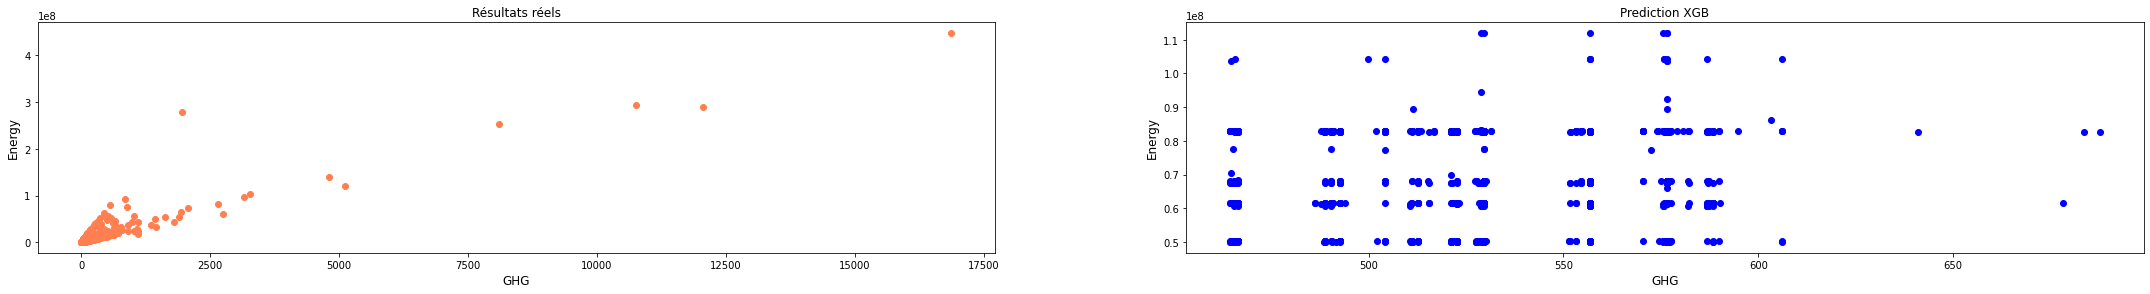

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2)
        
ax1.scatter(df_energystar['TotalGHGEmissions_avg'], df_energystar['SiteEnergyUse(kBtu)_avg'], c='coral')
ax1.set_title(f'Résultats réels')
ax1.set_xlabel("GHG", size = 12)
ax1.set_ylabel("Energy", size = 12)
        
ax2.scatter(df_energystar['GHG_predict'], df_energystar['Energy_predict'], c='b')
ax2.set_title(f'Prediction XGB')
ax2.set_xlabel("GHG", size = 12)
ax2.set_ylabel("Energy", size = 12)     

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

plt.show()